# Traffic Forecasting
#### CHAPTER 09: _Interpretation Methods for Multivariate Forecasting and Sensitivity Analysis_
##### From **Interpretable Machine Learning with Python 2nd Edition** by Serg Masís, published by Packt
##### (Main example with "LSTM_traffic_168_compact1" model)

## The Preparations

### Installing the Libraries

In [ ]:
!pip install --force-reinstall pandas==1.3.5
!pip install --force-reinstall numpy==1.21.6
!pip install --force-reinstall scikit-learn==1.0.2
!pip install --force-reinstall tensorflow==2.2.0
!pip install --force-reinstall Keras==2.2.4
!pip install --force-reinstall matplotlib==3.5.1
!pip install --force-reinstall seaborn==0.11.0

!pip install --force-reinstall shap==0.37.0

In [ ]:
!pip install --force-reinstall alibi==0.6.5
!pip install --force-reinstall distython==0.0.3
!pip install --force-reinstall SALib==1.3.11

### Loading the Libraries

In [1]:
import math
import os
import warnings
warnings.filterwarnings('ignore')
import mldatasets
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils.data_utils import get_file
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
from alibi.explainers import IntegratedGradients
from distython import HEOM
import shap
from SALib.sample import morris as ms
from SALib.analyze import morris as ma
from SALib.plotting import morris as mp
from SALib.sample import saltelli as ss
from SALib.analyze import sobol as sa
from SALib.plotting import bar as sp

Using TensorFlow backend.


In [2]:
print(tf.__version__)

2.2.0


### Understanding and Preparing the Data

In [3]:
traffic_df = mldatasets.load("traffic-volume-v2", prepare=True)

https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python-2E/raw/main/datasets/traffic-volume-2e.csv.zip downloaded to /Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/programming/Chapter9/data/traffic-volume-2e.csv.zip
/Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/programming/Chapter9/data/traffic-volume-2e.csv.zip uncompressed to /Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/programming/Chapter9/data/traffic-volume-2e.csv
1 dataset files found in /Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/programming/Chapter9/data/traffic-volume-2e.csv folder
parsing /Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/programming/Chapter9/data/traffic-volume-2e.csv/traffic-volume-2e.csv


In [4]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52536 entries, 2012-10-03 00:00:00 to 2018-09-30 23:00:00
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   dow              52536 non-null  int64  
 1   hr               52536 non-null  int64  
 2   temp             52536 non-null  float64
 3   rain_1h          52536 non-null  float64
 4   snow_1h          52536 non-null  float64
 5   cloud_coverage   52536 non-null  float64
 6   is_holiday       52536 non-null  int64  
 7   traffic_volume   52536 non-null  int64  
 8   weather_Clear    52536 non-null  uint8  
 9   weather_Clouds   52536 non-null  uint8  
 10  weather_Haze     52536 non-null  uint8  
 11  weather_Mist     52536 non-null  uint8  
 12  weather_Other    52536 non-null  uint8  
 13  weather_Rain     52536 non-null  uint8  
 14  weather_Snow     52536 non-null  uint8  
 15  weather_Unknown  52536 non-null  uint8  
dtypes: float64(4), int64(4)

#### Data Understanding

In [5]:
lb = 168

sns.set()

##### Understanding Weeks

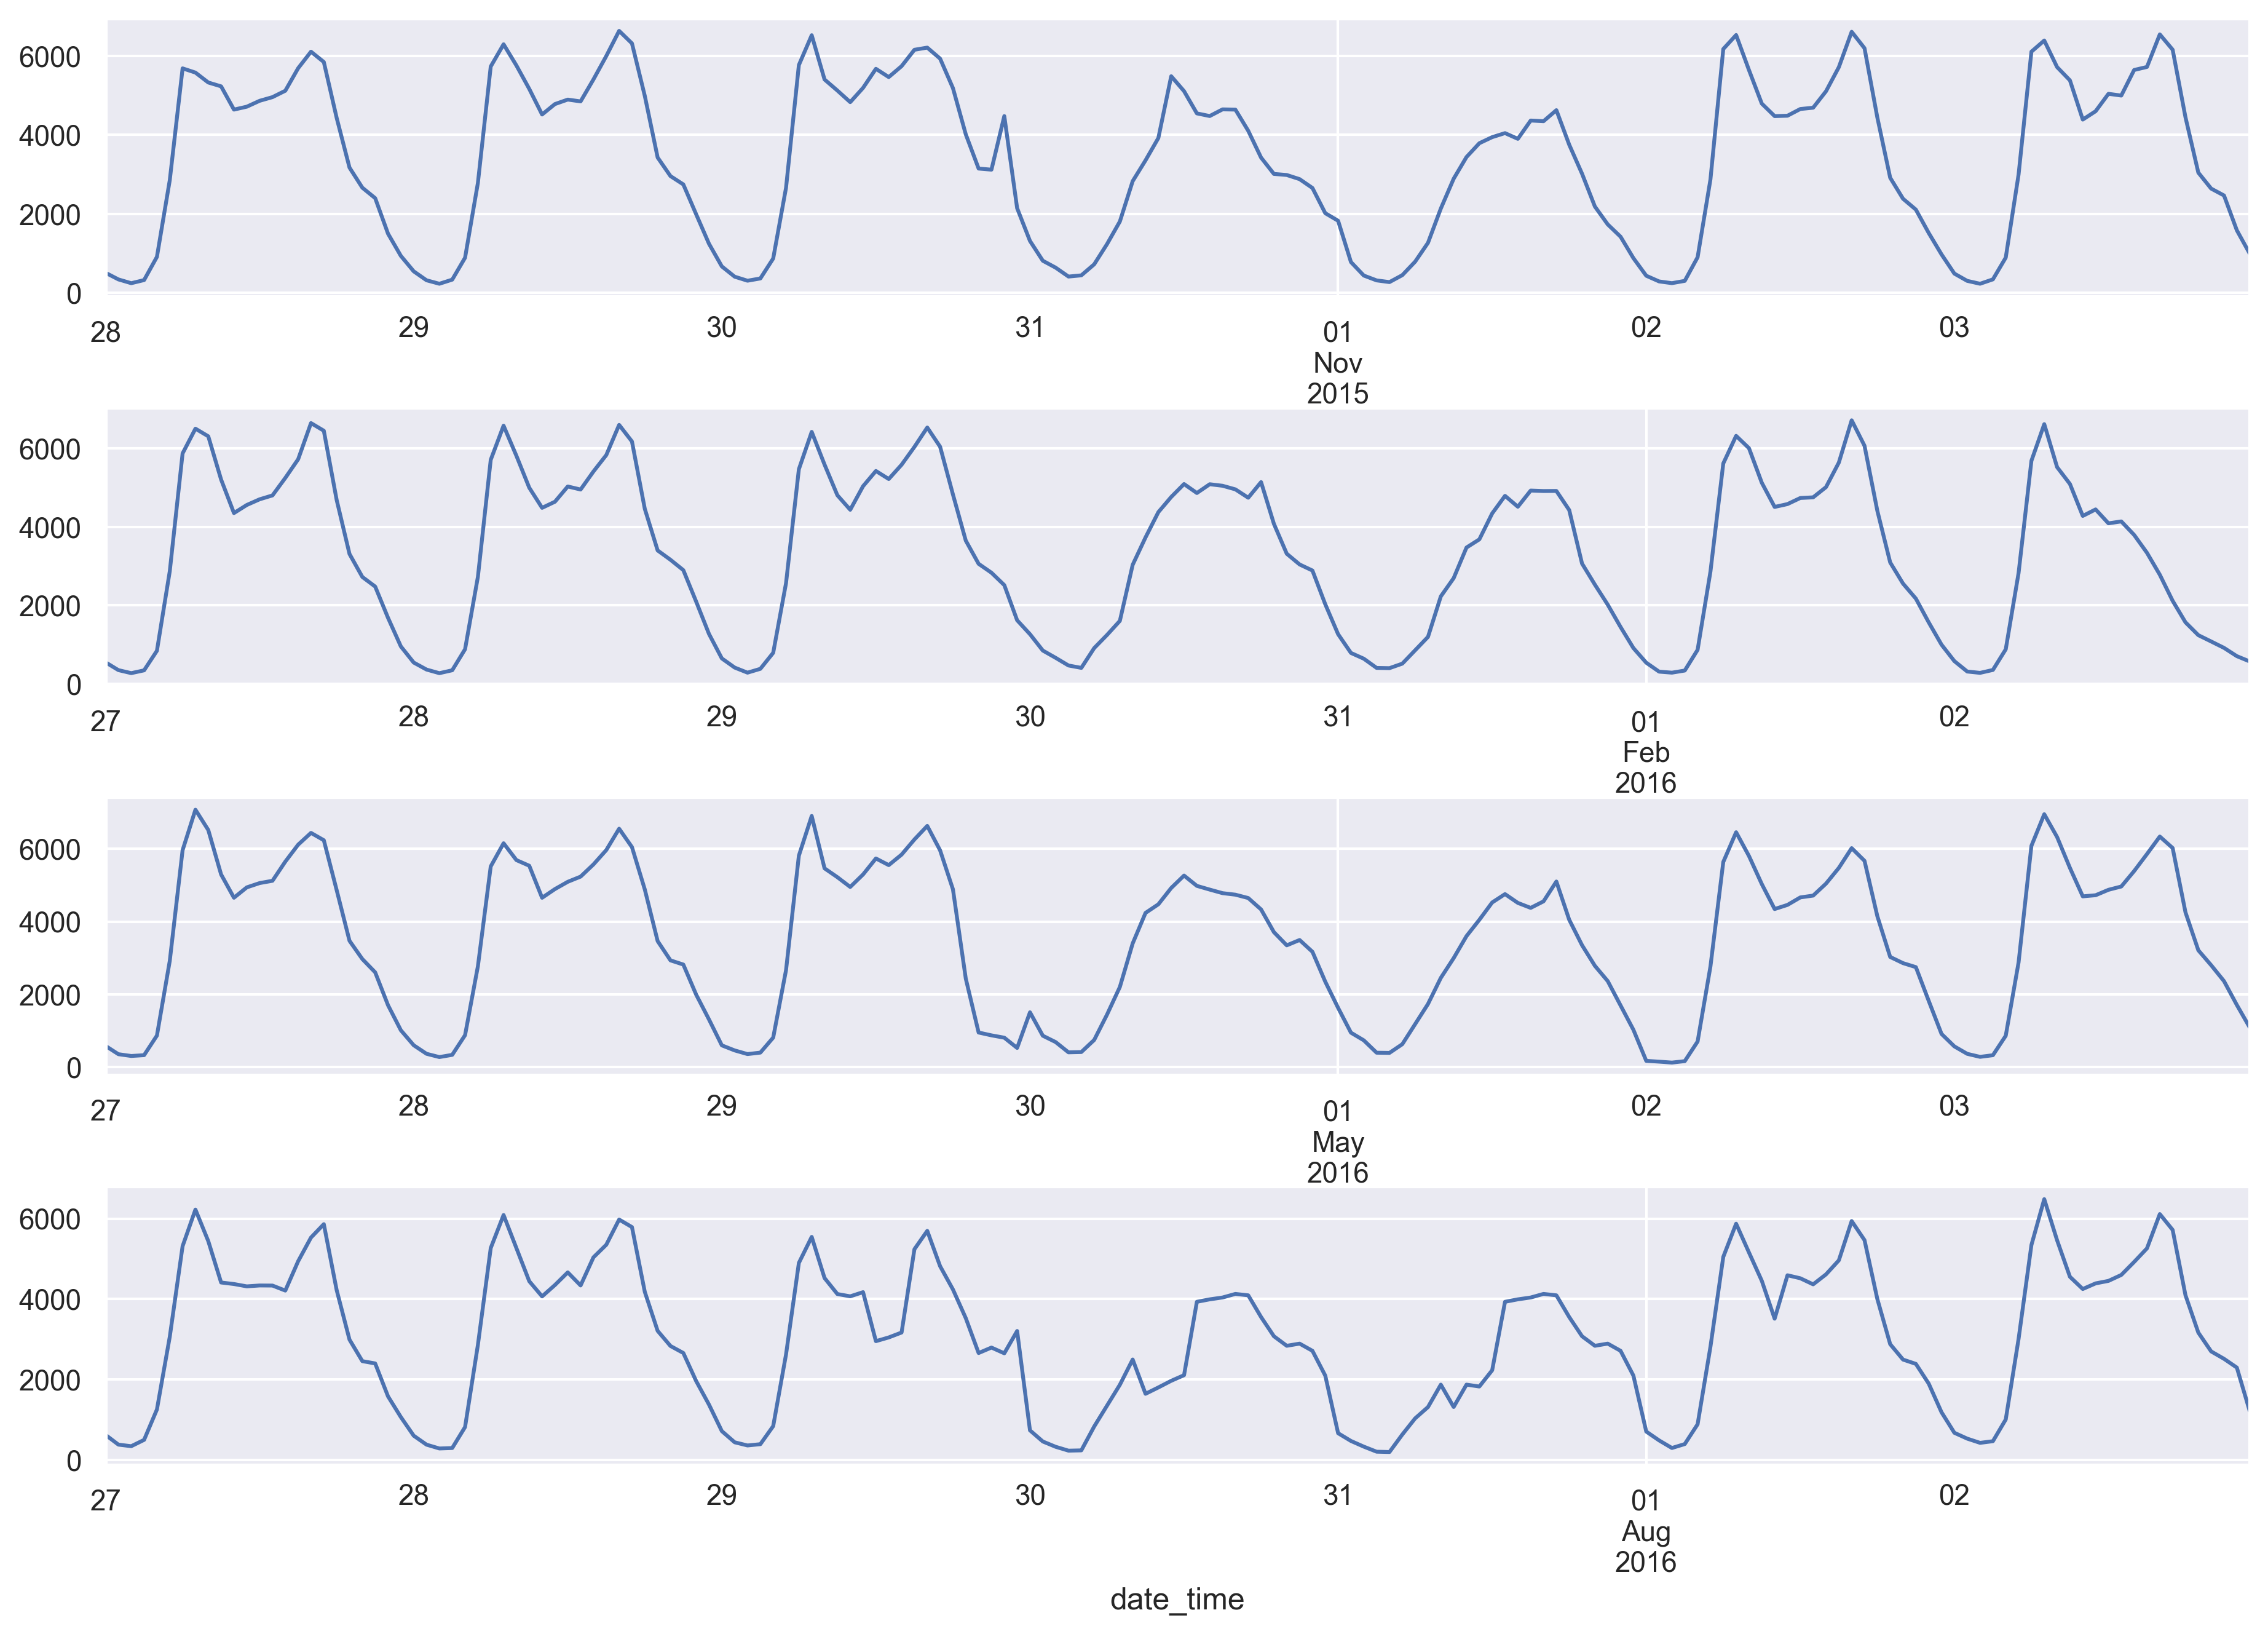

In [130]:
fig, (ax0,ax1,ax2,ax3) = plt.subplots(4,1, figsize=(15,8))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4)
traffic_df[(lb*160):(lb*161)].traffic_volume.plot(ax=ax0)
traffic_df[(lb*173):(lb*174)].traffic_volume.plot(ax=ax1)
traffic_df[(lb*186):(lb*187)].traffic_volume.plot(ax=ax2)
traffic_df[(lb*199):(lb*200)].traffic_volume.plot(ax=ax3)
plt.show()

##### Understanding Days

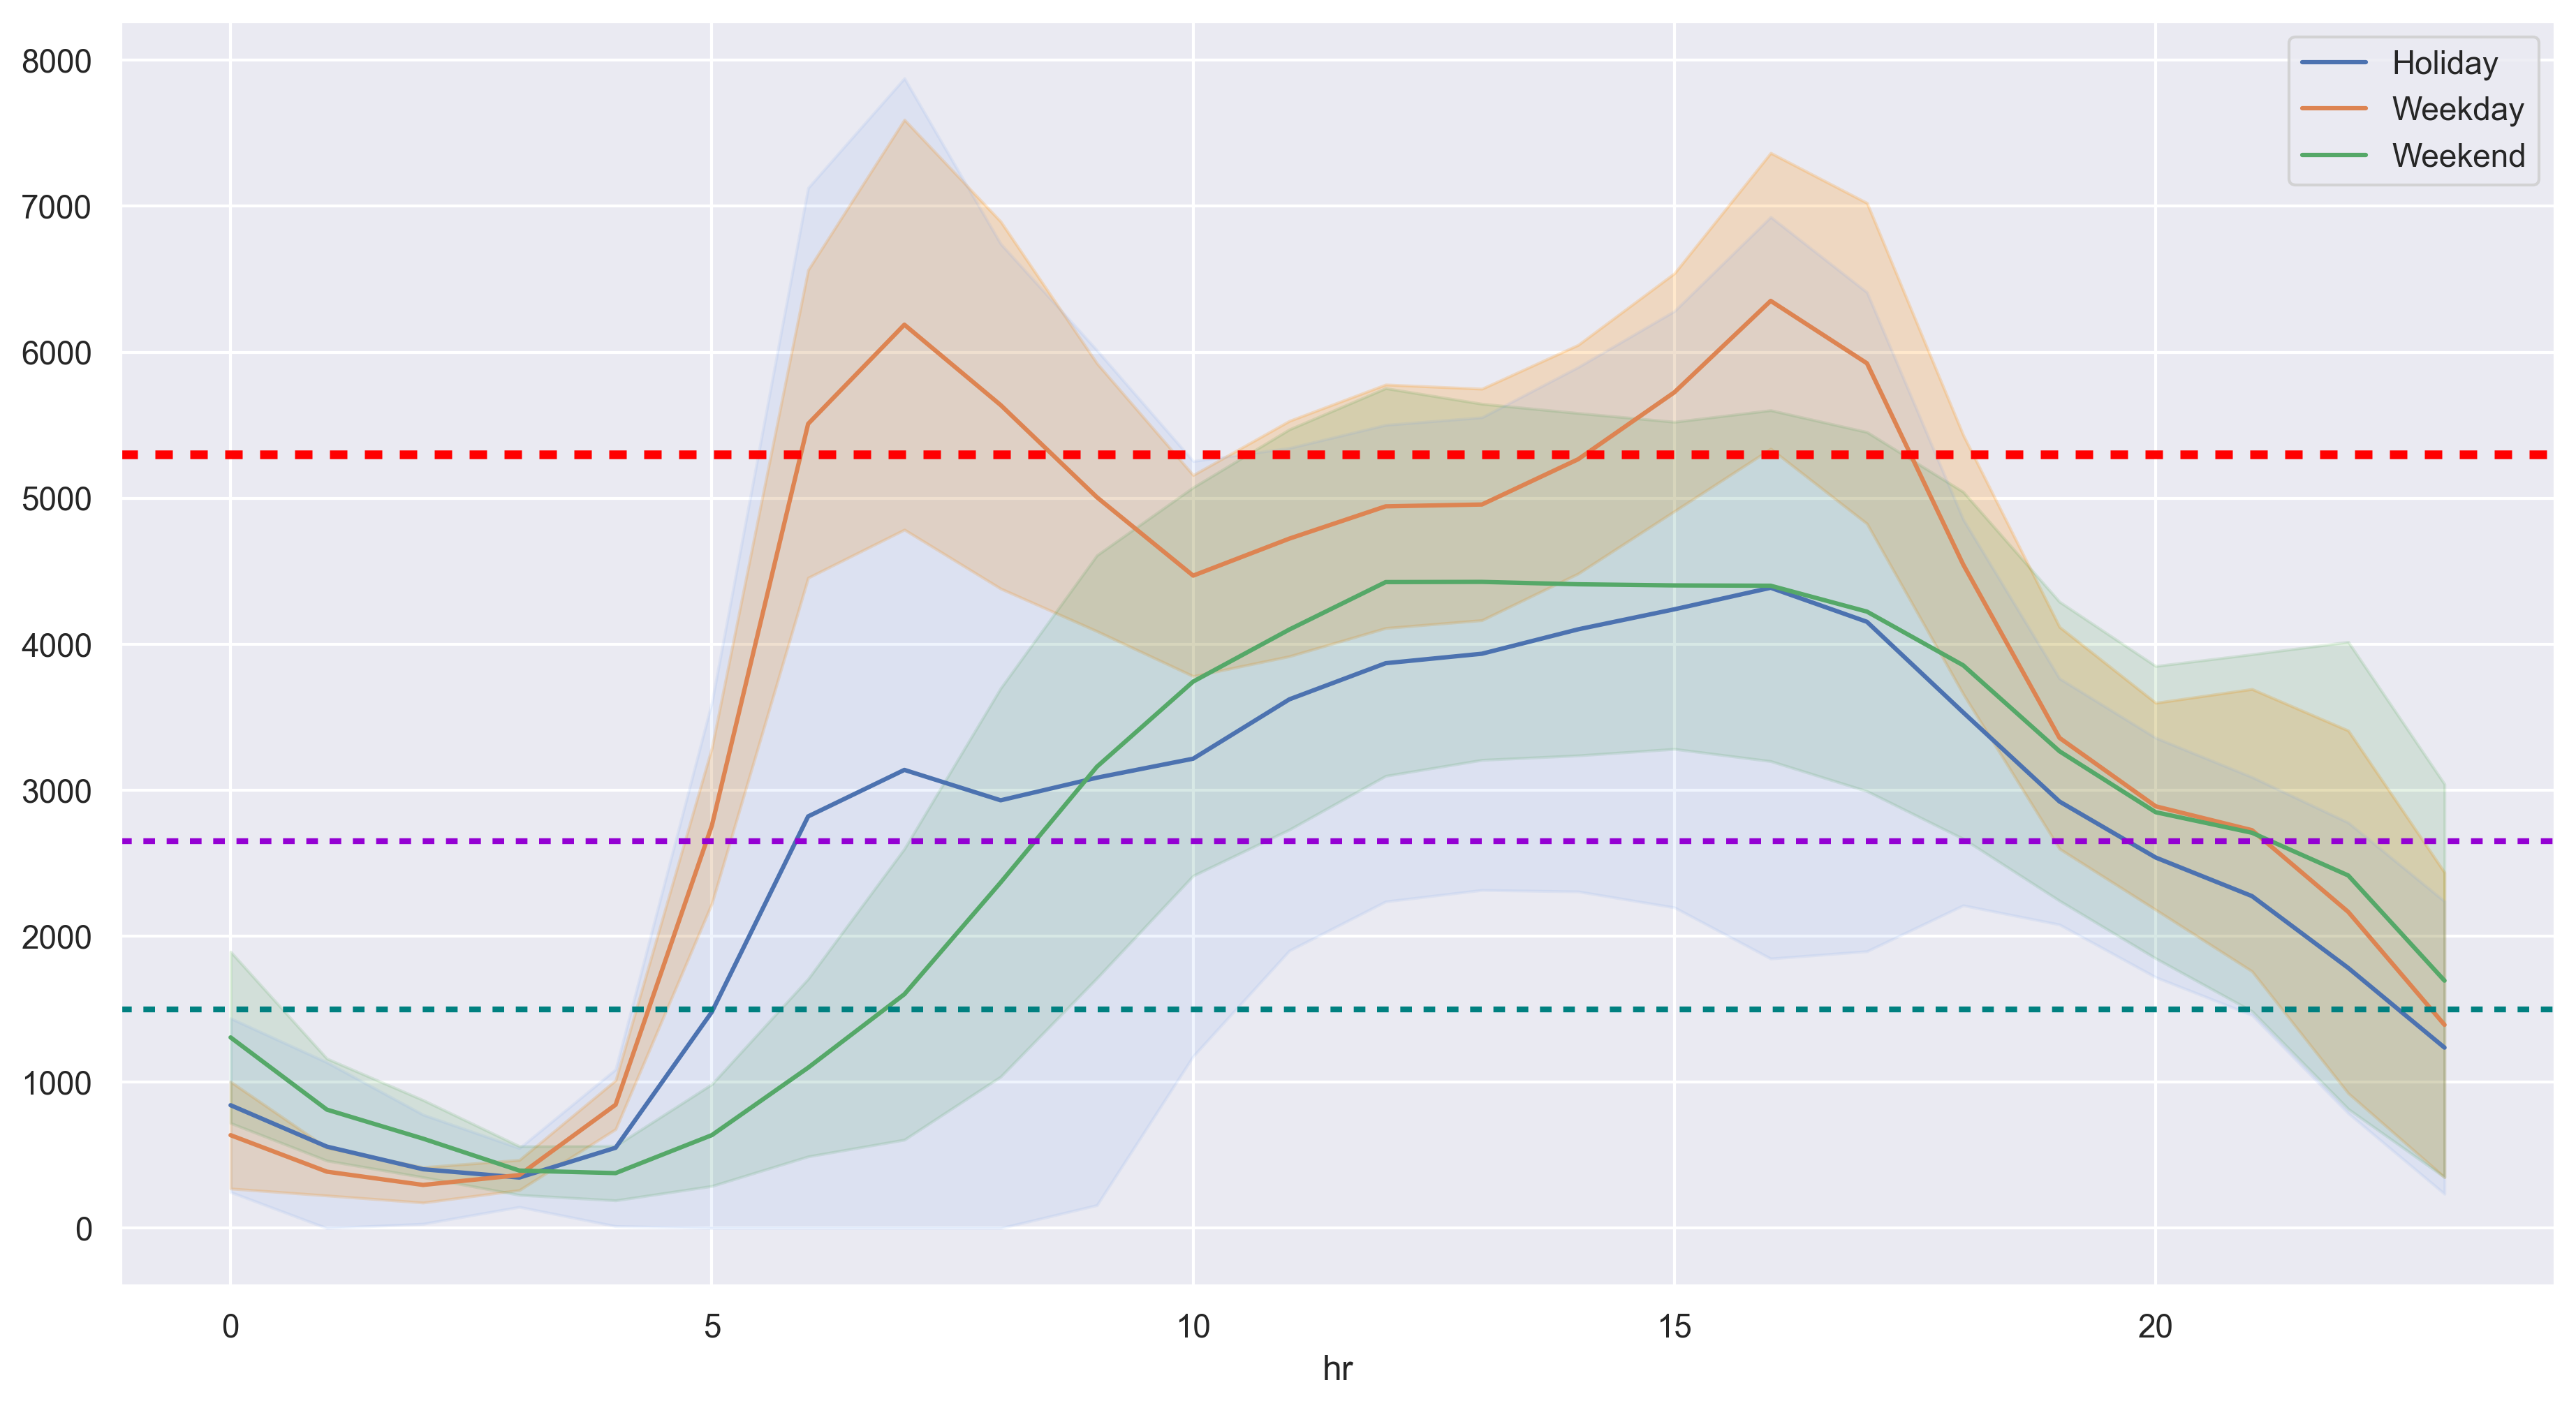

In [7]:
weekend_df = traffic_df[['hr', 'dow', 'is_holiday', 'traffic_volume']].copy()
weekend_df['type_of_day'] = np.where(weekend_df.is_holiday == 1, 'Holiday',
                                   np.where(weekend_df.dow >= 5, 'Weekend', 'Weekday'))
weekend_df = weekend_df.groupby(['type_of_day','hr'])['traffic_volume'].agg(['mean','std']).\
                reset_index().pivot(index='hr', columns='type_of_day', values=['mean', 'std'])
weekend_df.columns = ['_'.join(col).strip().replace('mean_','')\
                      for col in weekend_df.columns.values]
fig, ax = plt.subplots(figsize=(15,8))
weekend_df[['Holiday','Weekday','Weekend']].plot(ax=ax)
plt.fill_between(weekend_df.index,\
                 np.maximum(weekend_df.Weekday - 2 * weekend_df.std_Weekday, 0),\
                 weekend_df.Weekday + 2 * weekend_df.std_Weekday,
                 color='darkorange', alpha=0.2)
plt.fill_between(weekend_df.index,\
                 np.maximum(weekend_df.Weekend - 2 * weekend_df.std_Weekend, 0),\
                 weekend_df.Weekend + 2 * weekend_df.std_Weekend,
                 color='green', alpha=0.1)
plt.fill_between(weekend_df.index,\
                 np.maximum(weekend_df.Holiday - 2 * weekend_df.std_Holiday, 0),\
                 weekend_df.Holiday + 2 * weekend_df.std_Holiday,
                 color='cornflowerblue', alpha=0.1)
ax.axhline(y=5300, linewidth=3, color='red', dashes=(2,2))
ax.axhline(y=2650, linewidth=2, color='darkviolet', dashes=(2,2))
ax.axhline(y=1500, linewidth=2, color='teal', dashes=(2,2))
plt.show()

#### Data Preparation

In [8]:
train = traffic_df[:-104*lb]
valid = traffic_df[-104*lb:-52*lb]
test = traffic_df[-52*lb:]

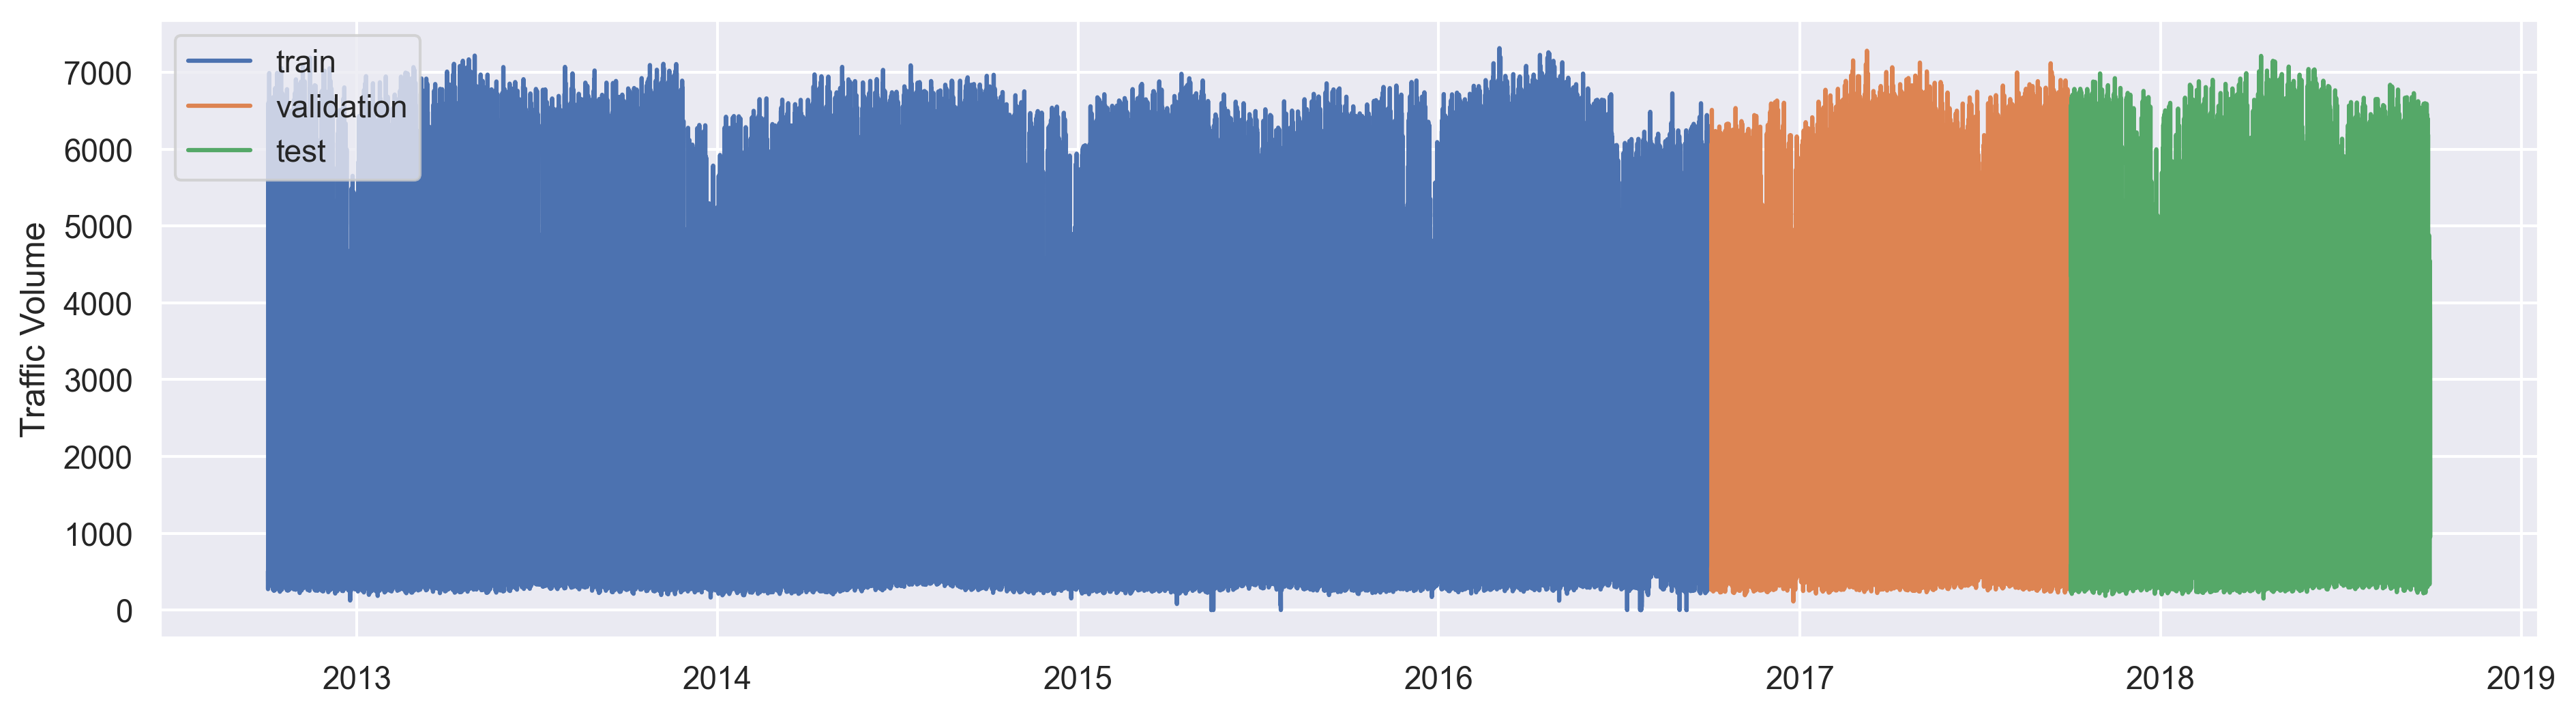

CPU times: user 3.38 s, sys: 178 ms, total: 3.55 s
Wall time: 3.39 s


In [9]:
%%time
plt.figure(figsize=(15,4))
plt.plot(train.index.values, train.traffic_volume.values,\
         label='train')
plt.plot(valid.index.values, valid.traffic_volume.values,\
         label='validation')
plt.plot(test.index.values, test.traffic_volume.values,\
         label='test')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

In [10]:
y_scaler = MinMaxScaler()
y_scaler.fit(traffic_df[['traffic_volume']])
X_scaler = MinMaxScaler()
X_scaler.fit(traffic_df.drop(['traffic_volume'], axis=1))

MinMaxScaler()

In [11]:
y_train = y_scaler.transform(train[['traffic_volume']])
X_train = X_scaler.transform(train.drop(['traffic_volume'], axis=1))
y_test = y_scaler.transform(test[['traffic_volume']])
X_test = X_scaler.transform(test.drop(['traffic_volume'], axis=1))

In [12]:
%%time
gen_train = TimeseriesGenerator(X_train, y_train, length=lb,\
                                    batch_size=24)
gen_test = TimeseriesGenerator(X_test, y_test, length=lb,\
                                   batch_size=24)

print("gen_train:\t%s\t×\t%s\t→\t%s" % (len(gen_train),\
                                    gen_train[0][0].shape,\
                                    gen_train[0][1].shape))
print("gen_test:\t%s\t×\t%s\t→\t%s" % (len(gen_test),\
                                   gen_test[0][0].shape,\
                                   gen_test[0][1].shape))

gen_train:	1454	×	(24, 168, 15)	→	(24, 1)
gen_test:	357	×	(24, 168, 15)	→	(24, 1)
CPU times: user 1.71 ms, sys: 1.73 ms, total: 3.44 ms
Wall time: 1.96 ms


In [13]:
rand = 9
os.environ['PYTHONHASHSEED']=str(rand)
tf.random.set_seed(rand)
np.random.seed(rand)

### Loading the LSTM Model

In [14]:
model_name = 'LSTM_traffic_168_compact1.hdf5'
model_path = get_file(model_name,\
            'https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python-2E/blob/main/models/{}?raw=true'.format(model_name))

lstm_traffic_mdl = tf.keras.models.load_model(model_path, compile=False)
lstm_traffic_mdl.summary()

Model: "LSTM_traffic_168_compact1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Bidir_LSTM (Bidirectional)   (24, 168)                 67200     
_________________________________________________________________
Dropout (Dropout)            (24, 168)                 0         
_________________________________________________________________
Dense (Dense)                (24, 1)                   169       
Total params: 67,369
Trainable params: 67,369
Non-trainable params: 0
_________________________________________________________________


## Assessing Time-Series Models with Traditional Interpretation Methods

### Using Standard Regression Metrics

357/357 [==============================] - 6s 17ms/step


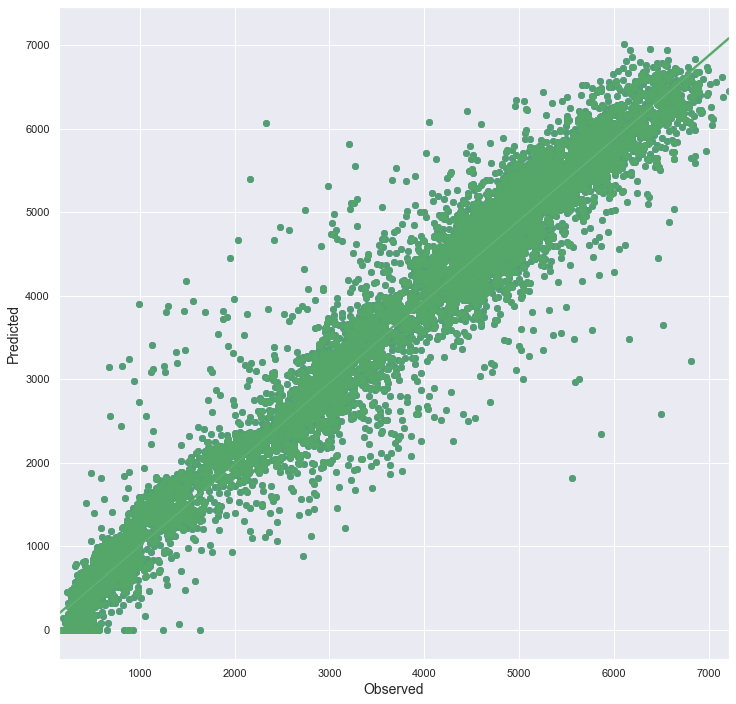

RMSE_train: 422.7644	RMSE_test: 430.2689	r2: 0.9528


In [15]:
y_train_pred, y_test_pred, y_train, y_test =\
    mldatasets.evaluate_reg_mdl(lstm_traffic_mdl, gen_train, gen_test,\
                                y_train, y_test, scaler=y_scaler, y_truncate=True,\
                                predopts={"verbose":1})

### Predictive Error Aggregations

In [19]:
evaluate_df = test.iloc[-y_test_pred.shape[0]:,[0,1,6,7]].\
                rename(columns={'traffic_volume':'actual_traffic'})
evaluate_df['predicted_traffic'] = y_test_pred
evaluate_df['type_of_day'] = np.where(evaluate_df.is_holiday == 1, 'Holiday',
                                   np.where(evaluate_df.dow >= 5, 'Weekend', 'Weekday'))
evaluate_df.drop(['dow','is_holiday'], axis=1, inplace=True)

In [20]:
evaluate_df

hr  actual_traffic  predicted_traffic type_of_day
date_time                                                             
2017-10-09 00:00:00   0             549         624.639648     Holiday
2017-10-09 01:00:00   1             304         211.869965     Holiday
2017-10-09 02:00:00   2             247          42.144981     Holiday
2017-10-09 03:00:00   3             337         202.197357     Holiday
2017-10-09 04:00:00   4             854         747.119568     Holiday
...                  ..             ...                ...         ...
2018-09-30 19:00:00  19            3543        3172.783203     Weekend
2018-09-30 20:00:00  20            2781        2731.412842     Weekend
2018-09-30 21:00:00  21            2159        2349.529297     Weekend
2018-09-30 22:00:00  22            1450        1883.153564     Weekend
2018-09-30 23:00:00  23             954        1406.834351     Weekend

[8568 rows x 4 columns]

In [21]:
def rmse(g):
    rmse = np.sqrt(metrics.\
                   mean_squared_error(g['actual_traffic'],\
                                      g['predicted_traffic']))
    return pd.Series({'rmse': rmse})

evaluate_by_hr_df = evaluate_df.\
                        groupby(['type_of_day', 'hr']).apply(rmse).reset_index().\
                        pivot(index='hr', columns='type_of_day', values='rmse')

mean_by_daytype_s = evaluate_by_hr_df.mean(axis=0)

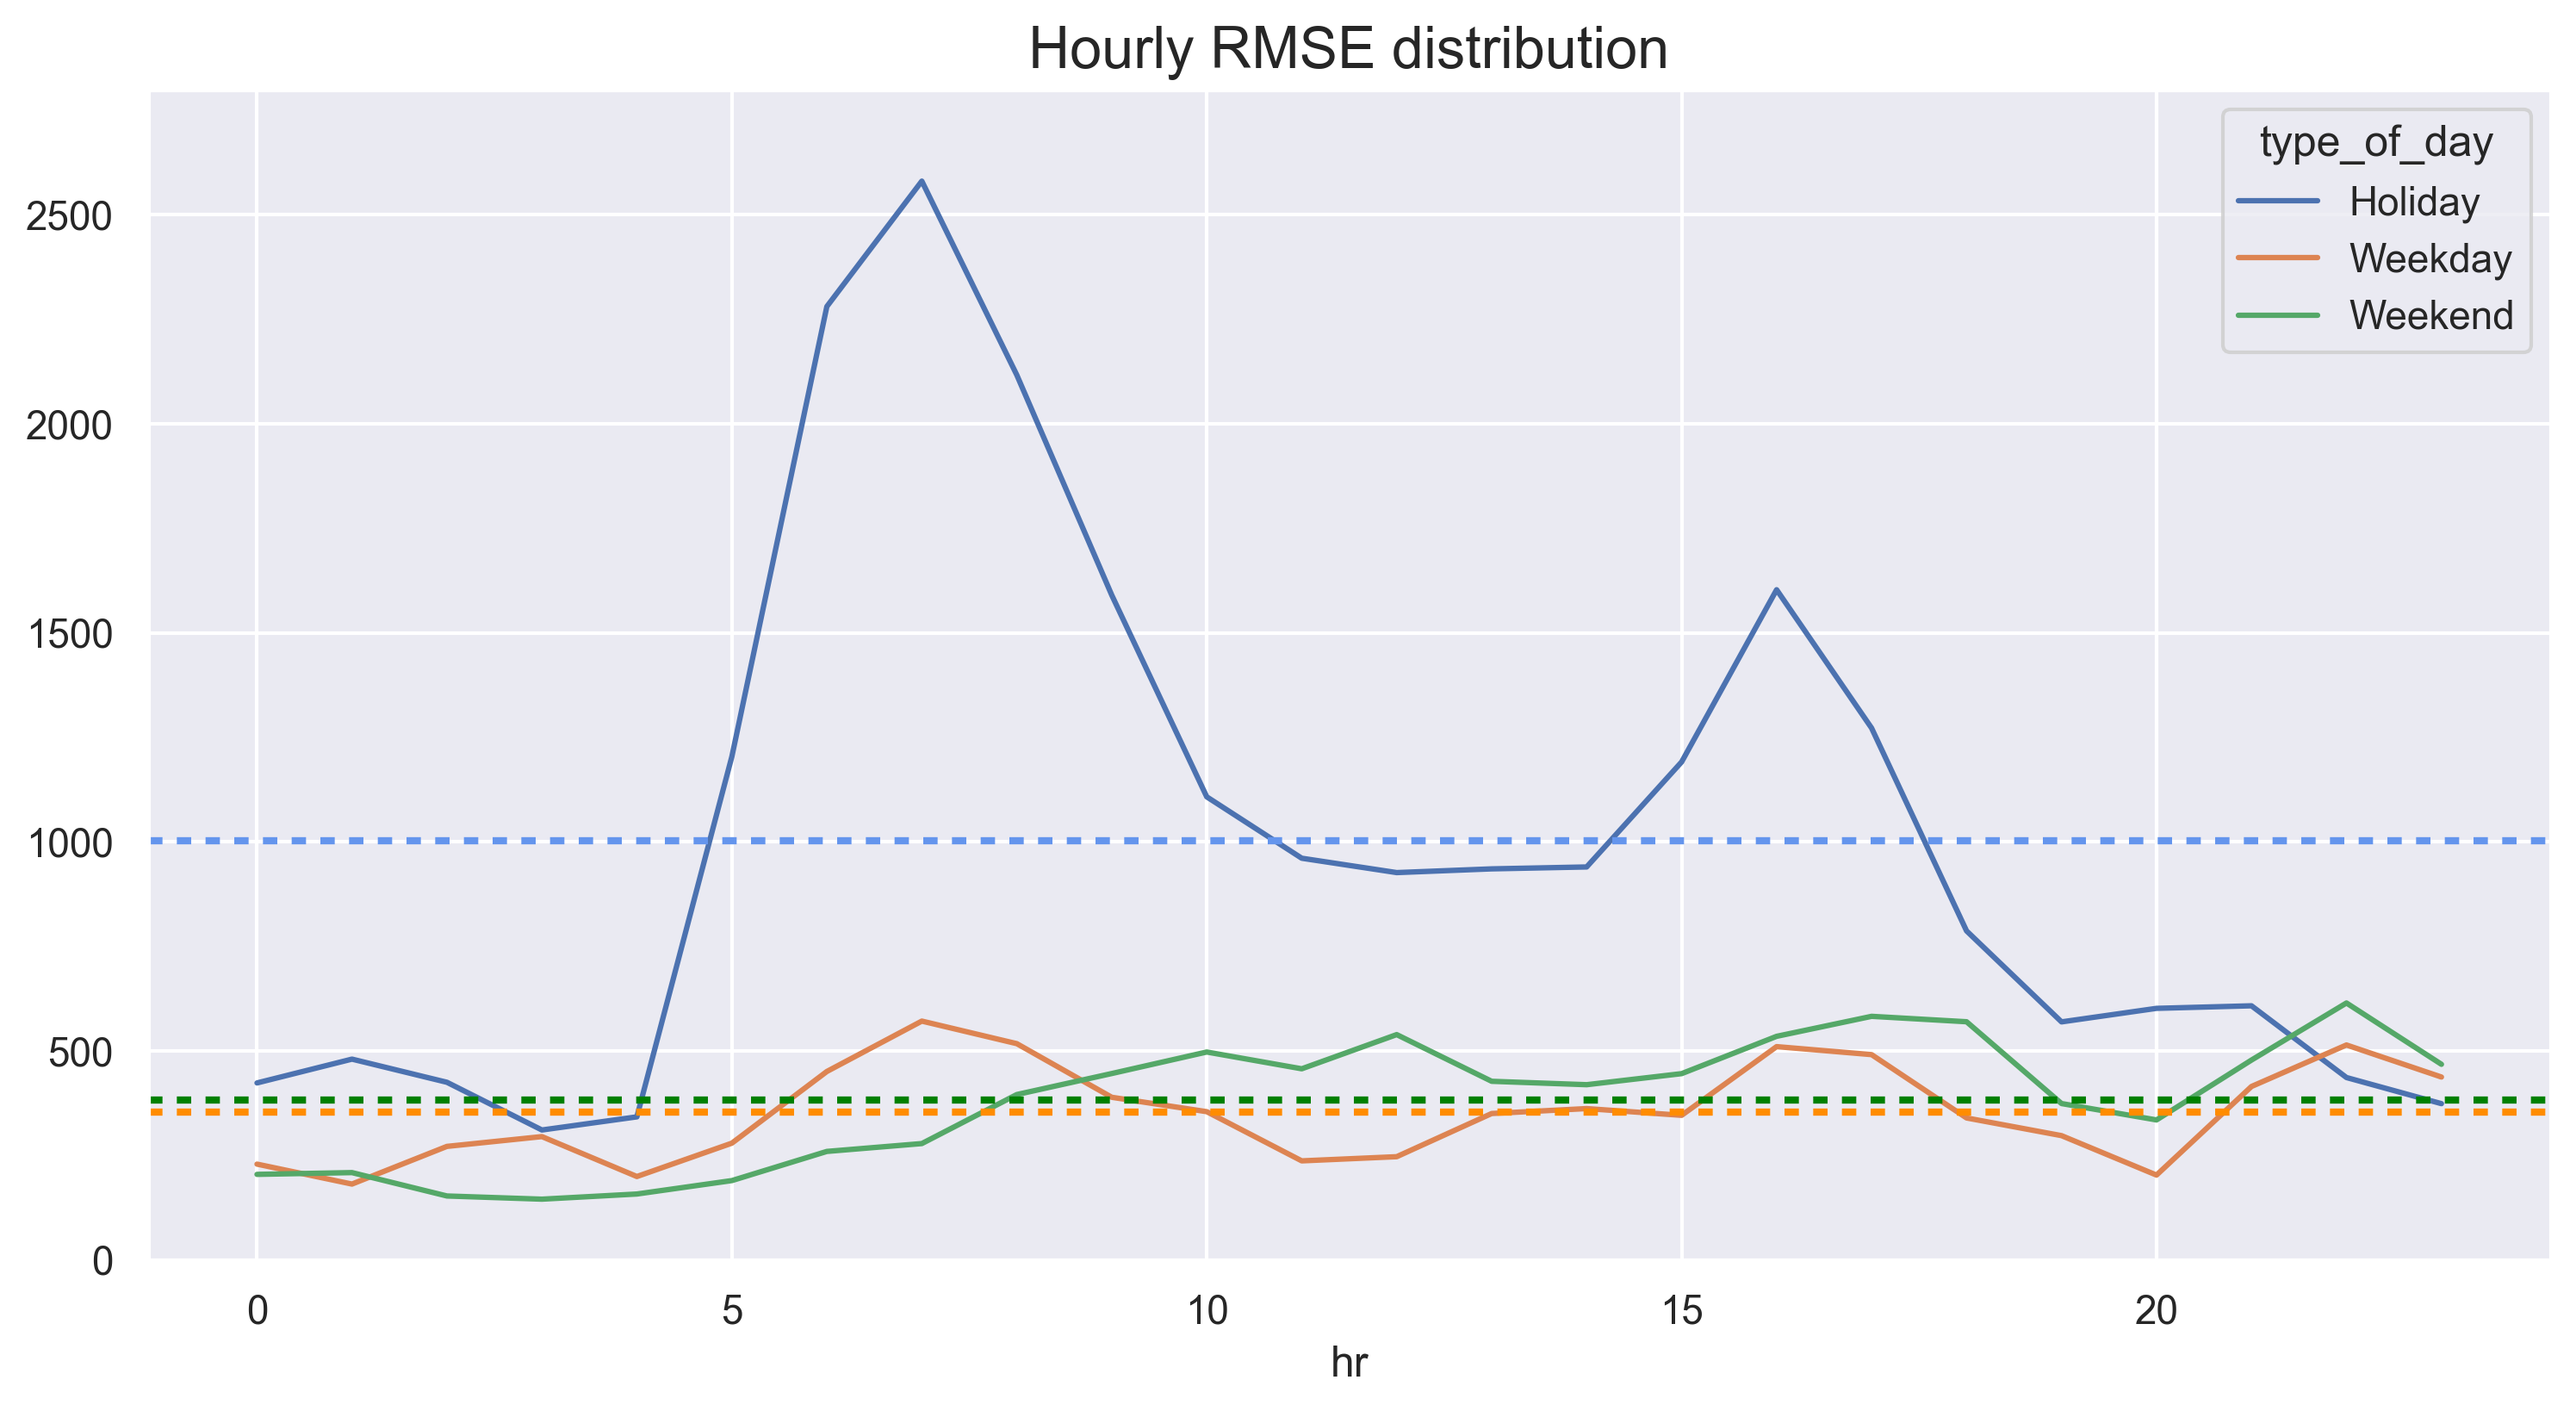

In [29]:
evaluate_by_hr_df.plot()
ax = plt.gca()
ax.set_title('Hourly RMSE distribution', fontsize=16)
ax.set_ylim([0,2800])
ax.axhline(y=mean_by_daytype_s.Holiday, linewidth=2,\
           color='cornflowerblue', dashes=(2,2))
ax.axhline(y=mean_by_daytype_s.Weekday, linewidth=2,\
           color='darkorange', dashes=(2,2))
ax.axhline(y=mean_by_daytype_s.Weekend, linewidth=2,\
           color='green', dashes=(2,2))
plt.show()

### Evaluating It Like A Classification Problem

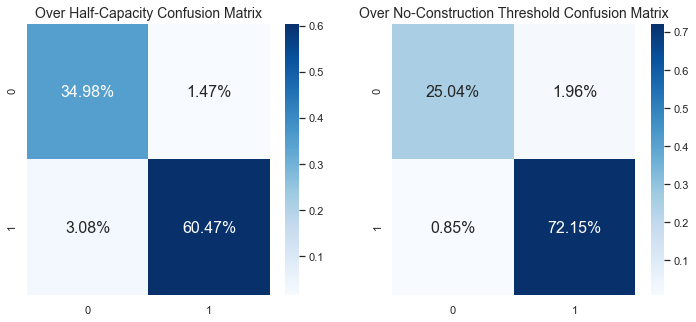

In [30]:
actual_over_half_cap = np.where(evaluate_df['actual_traffic'] >\
                                2650, 1, 0)
pred_over_half_cap = np.where(evaluate_df['predicted_traffic'] >\
                              2650, 1, 0)
actual_over_nc_thresh = np.where(evaluate_df['actual_traffic'] >\
                                1500, 1, 0)
pred_over_nc_thresh = np.where(evaluate_df['predicted_traffic'] >\
                              1500, 1, 0)

mldatasets.\
    compare_confusion_matrices(actual_over_half_cap, pred_over_half_cap,\
                               actual_over_nc_thresh, pred_over_nc_thresh,\
                               'Over Half-Capacity',\
                               'Over No-Construction Threshold')

## Generating LSTM Attributions with Integrated Gradients

In [31]:
y_all = y_scaler.transform(traffic_df[['traffic_volume']])
X_all = X_scaler.transform(traffic_df.drop(['traffic_volume'], axis=1))
gen_all = TimeseriesGenerator(X_all, y_all, length=lb, batch_size=24)

print("gen_all:\t%s\t×\t%s\t→\t%s" % (len(gen_all),\
                                    gen_all[0][0].shape,\
                                    gen_all[0][1].shape))

gen_all:	2182	×	(24, 168, 15)	→	(24, 1)


In [47]:
X_df = traffic_df.drop(['traffic_volume'], axis=1).reset_index(drop=True)

In [48]:
holiday_afternoon_s = X_df[(X_df.index >= 43800) & (X_df.dow==0) &\
                           (X_df.hr==16) & (X_df.is_holiday==1)].tail(1)

peak_morning_s = X_df[(X_df.index >= 43800) & (X_df.dow==2) &\
                      (X_df.hr==8) & (X_df.weather_Clouds==1) &\
                      (X_df.temp<20)].tail(1)

hot_saturday_s = X_df[(X_df.index >= 43800) & (X_df.dow==5) &\
                      (X_df.hr==12) & (X_df.temp>29) & (X_df.weather_Clear==1)].tail(1)

In [33]:
ig  = IntegratedGradients(lstm_traffic_mdl,\
                        n_steps=25, internal_batch_size=24)

In [131]:
nidx = holiday_afternoon_s.index.tolist()[0] - lb
batch_X = gen_all[nidx//24][0]
print(batch_X.shape)

(24, 168, 15)


It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


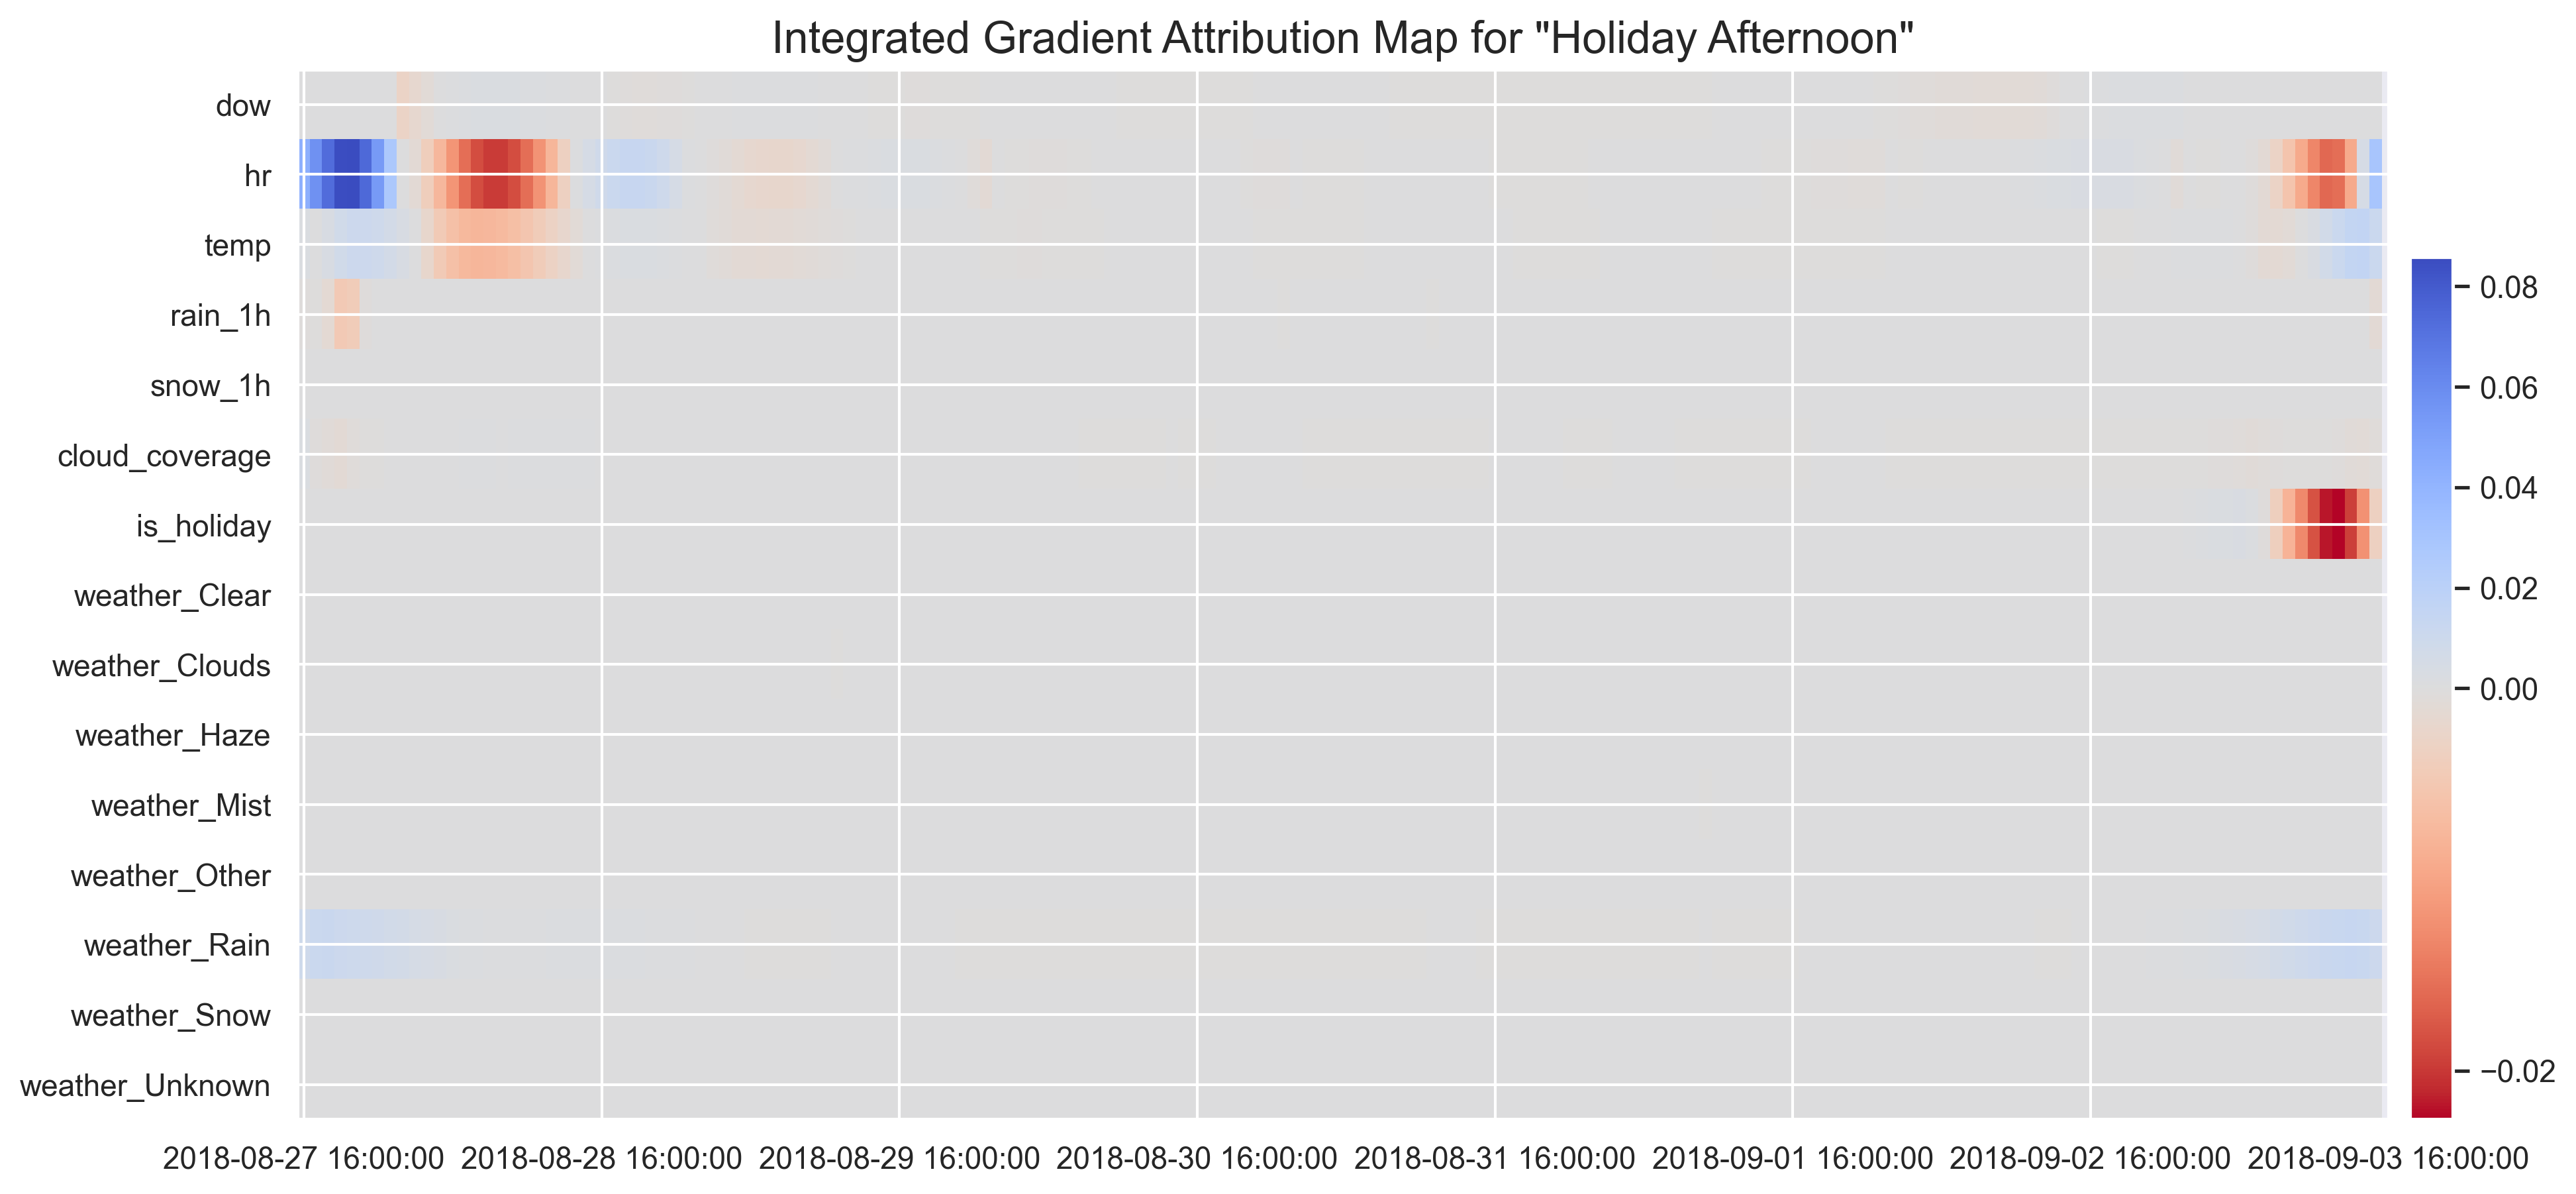

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


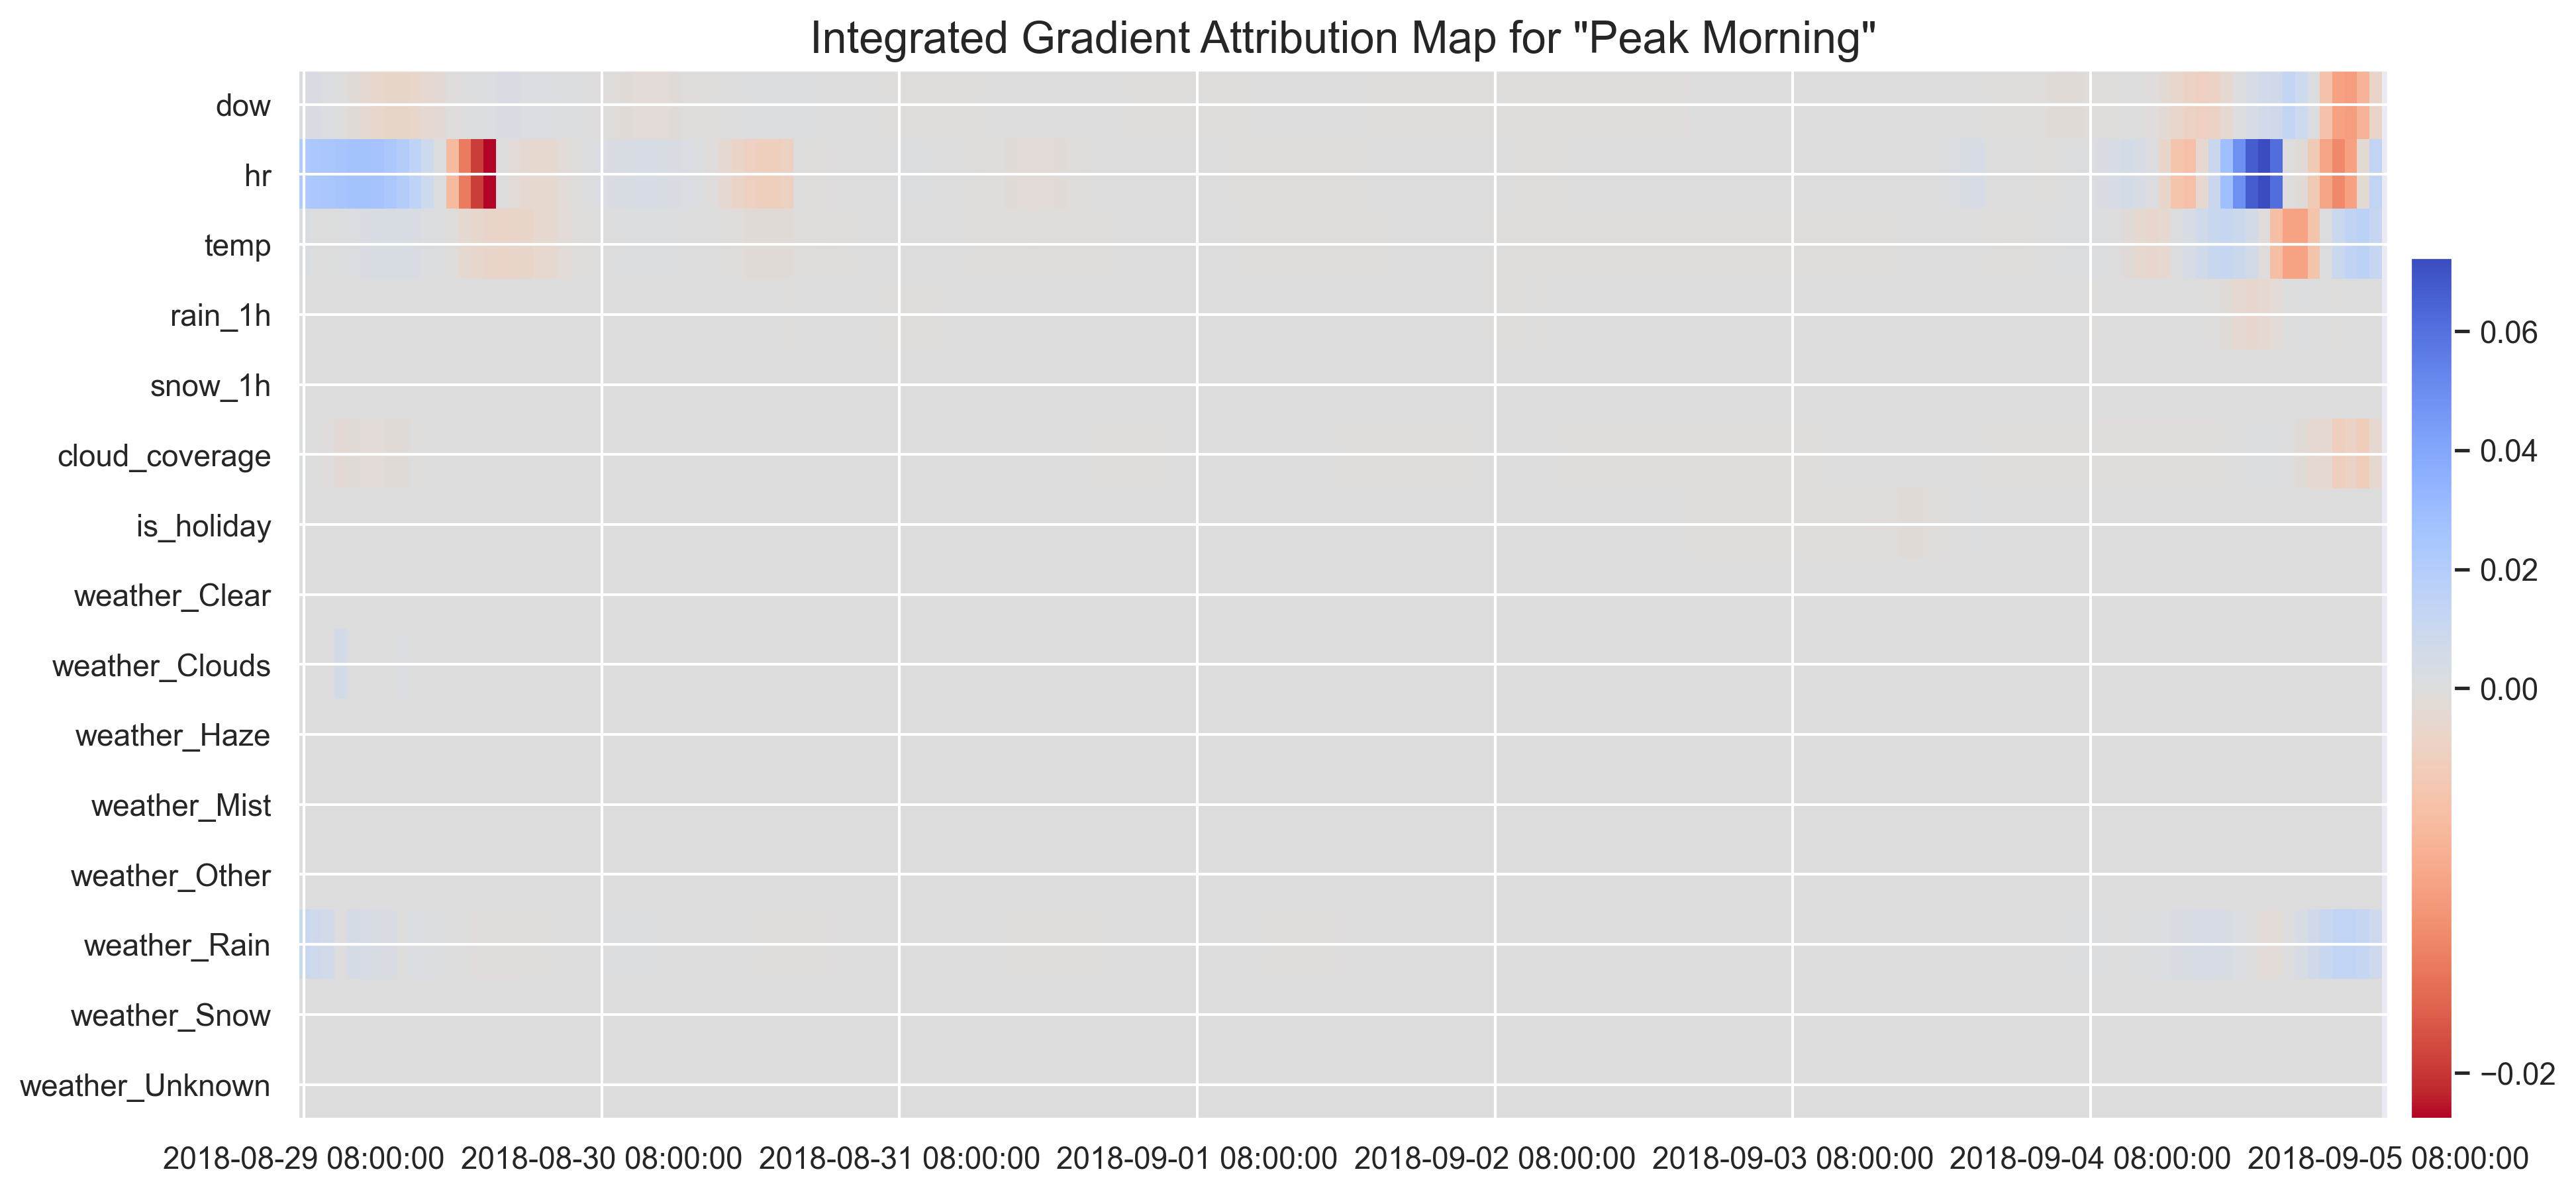

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


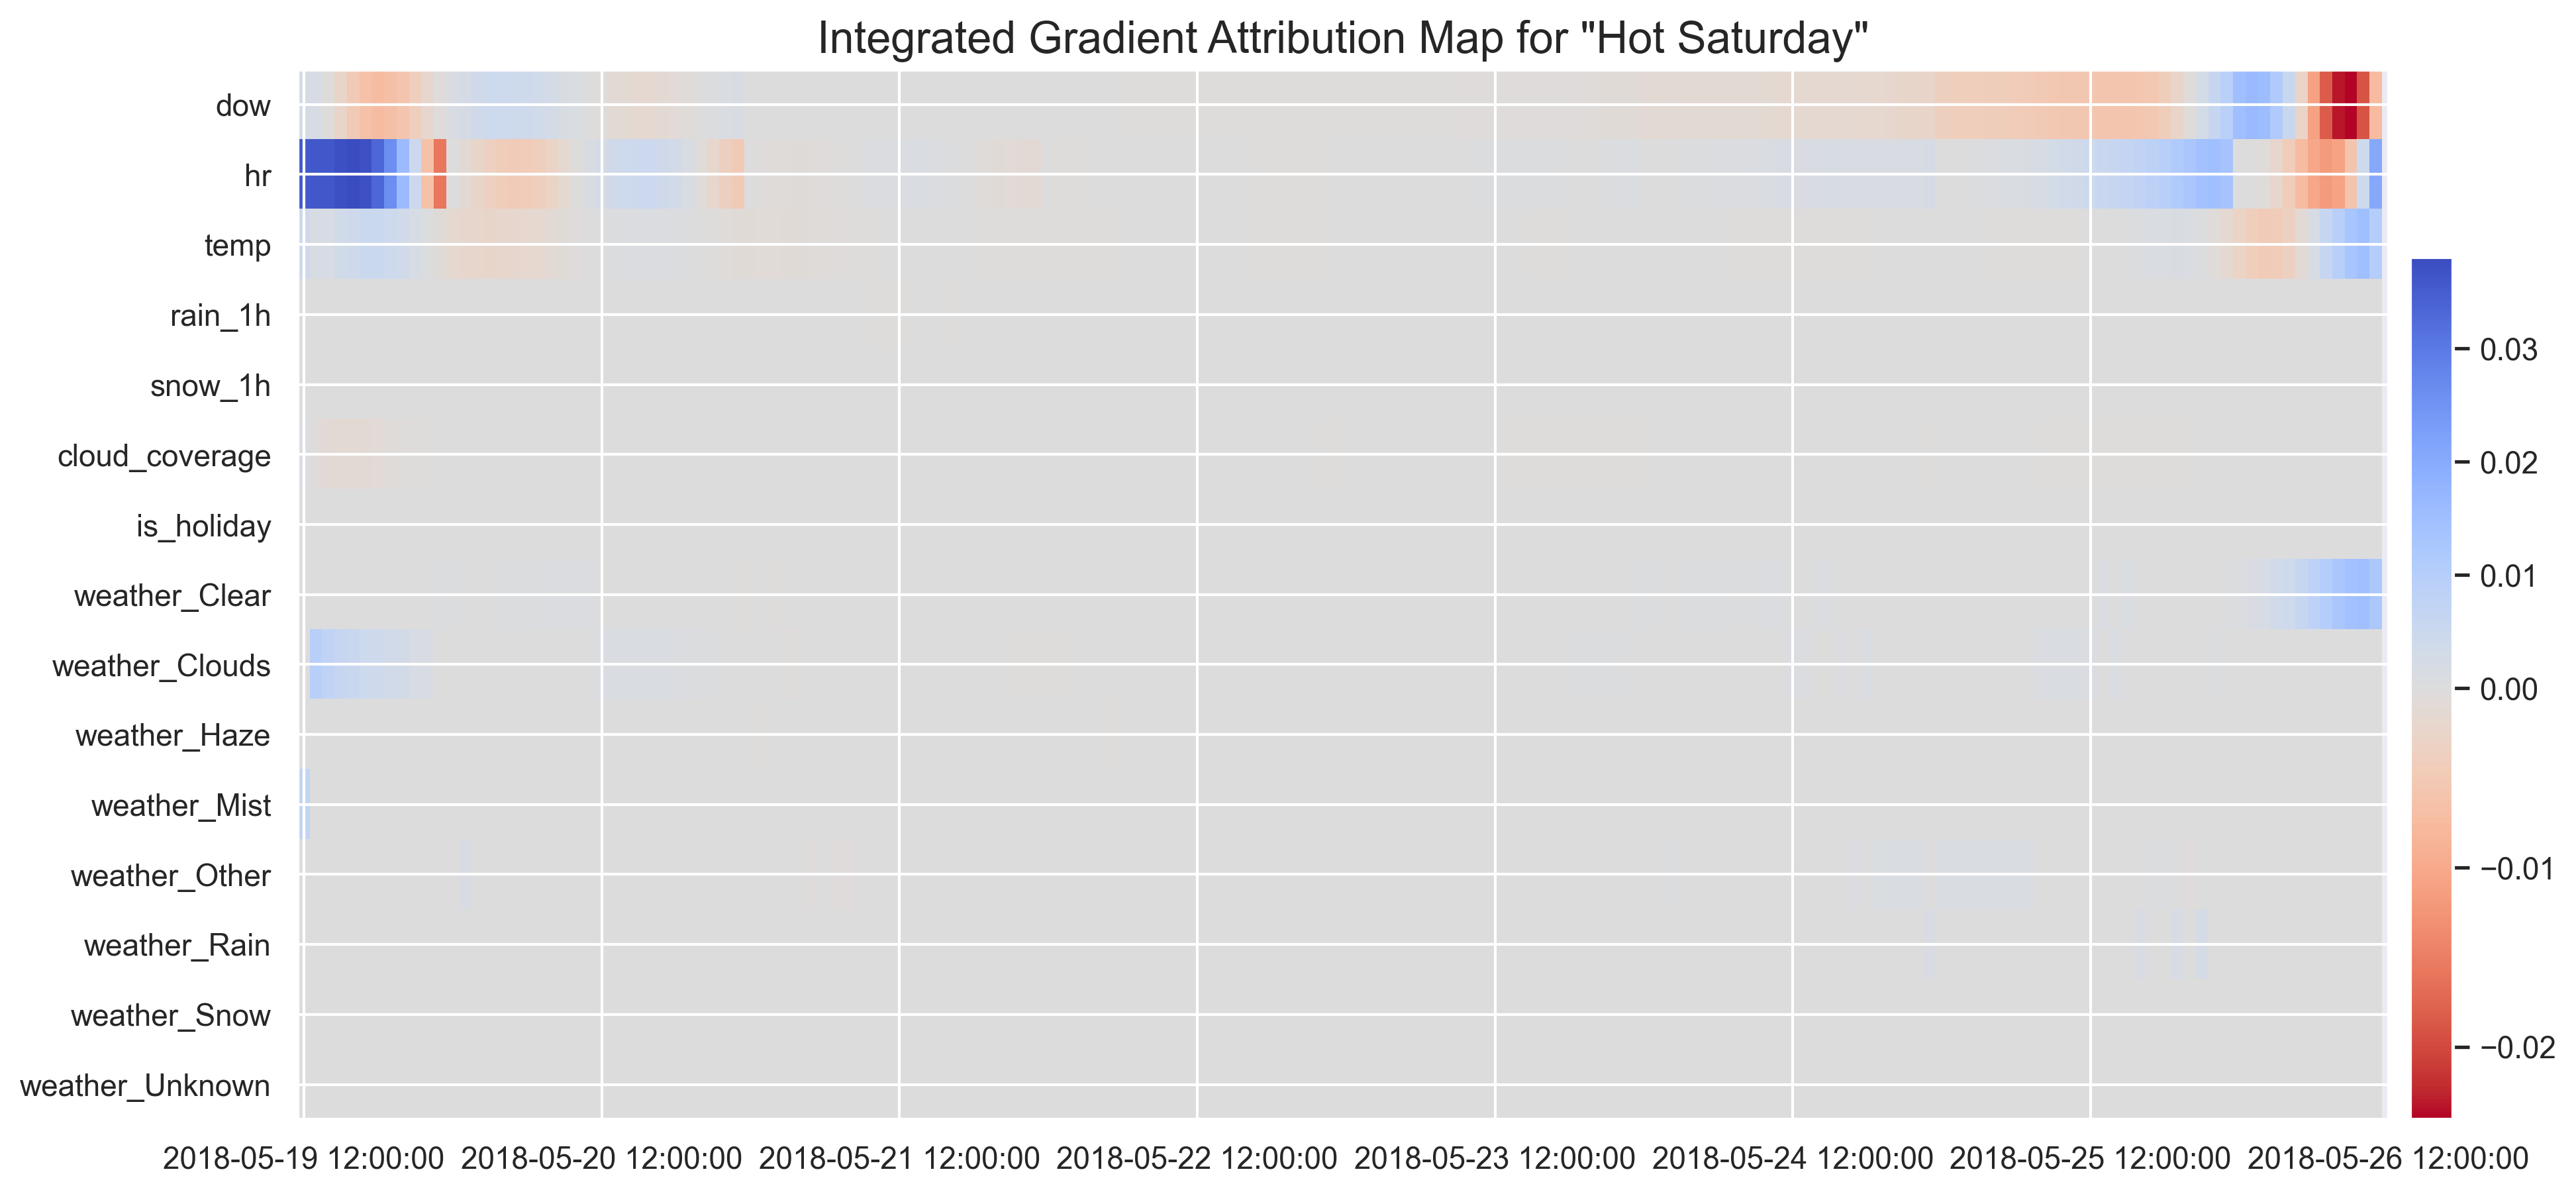

In [134]:
samples = [holiday_afternoon_s, peak_morning_s, hot_saturday_s]
sample_names = ['Holiday Afternoon', 'Peak Morning', 'Hot Saturday']

for s in range(len(samples)):
        
    nidx = samples[s].index.tolist()[0] - lb
    batch_X = gen_all[nidx//24][0]

    explanation = ig.explain(batch_X, target=None)
    attributions = explanation.attributions[0]
    attribution_img = np.transpose(attributions[nidx%24,:,:])

    end_date = traffic_df.iloc[samples[s].index].\
                            index.to_pydatetime()[0]
    date_range = pd.date_range(end=end_date, periods=8,\
                        freq='1D').to_pydatetime().tolist()
    columns = samples[s].columns.tolist()

    plt.figure(figsize=(14,7))
    plt.title('Integrated Gradient Attribution Map for "{}"'.\
              format(sample_names[s]), fontsize=16)
    divnorm = TwoSlopeNorm(vmin=attribution_img.min(), vcenter=0, vmax=attribution_img.max())
    plt.imshow(attribution_img, interpolation='nearest',\
               aspect='auto', cmap='coolwarm_r', norm=divnorm)
    plt.xticks(np.linspace(0,lb,8).astype(int), labels=date_range)
    plt.yticks([*range(15)], labels=columns)
    plt.colorbar(pad=0.01,fraction=0.02,anchor=(1.0,0.0))
    plt.show()

## Computing Global and Local Attributions with SHAP’s KernelExplainer

### Define Filter Function

In [44]:
def filt_fn(X_df, x, lookback):
    #print(x.tolist())
    x_ = x.copy()
    x_[0] = round(x_[0])
    x_[1] = round(x_[1])
    #x_[5] = round(x_[5])
    x_[6] = round(x_[6])
    if x_[1] < 0:
        x_[1] = 24 + x_[1]
        x_[0] = x_[0] - 1
    if x_[0] < 0:
        x_[0] = 7 + x_[0]
    x_[7] = round(x_[7])
    x_[8] = round(x_[8])
    x_[9] = round(x_[9])
    x_[10] = round(x_[10])
    x_[11] = round(x_[11])
    x_[12] = round(x_[12])
    x_[13] = round(x_[13])
    x_[14] = round(x_[14])
    #if not (x==x_).all(): print('\t%s' % x_.tolist())
    X_filt_df = X_df[(X_df.index >= lookback) & (X_df.dow==x_[0]) & (X_df.hr==x_[1]) &\
             (X_df.is_holiday==x_[5]) & (X_df.temp-5<=x_[2]) & (X_df.temp+5>=x_[2])]
    if X_filt_df.shape[0]==0:
        X_filt_df = X_df[(X_df.index >= lookback) & (X_df.dow==x_[0]) & (X_df.hr==x_[1]) &\
                         (X_df.is_holiday==x_[5]) & (X_df.temp-8<=x_[2]) & (X_df.temp+8>=x_[2])]
    if X_filt_df.shape[0]==0:
        X_filt_df = X_df[(X_df.index >= lookback) & (X_df.dow==x_[0]) & (X_df.hr==x_[1]) &\
                         (X_df.temp-11<=x_[2]) & (X_df.temp+11>=x_[2])]
    return X_filt_df, x_

### Define Distance Function

In [45]:
cat_idxs = np.where(traffic_df.drop(['traffic_volume'], axis=1).dtypes != np.float64)[0]
heom_dist = HEOM(X_df.values, cat_idxs)

In [46]:
print(cat_idxs)

[ 0  1  6  7  8  9 10 11 12 13 14]


### Define Predict Function

In [64]:
predict_fn = lambda X: mldatasets.\
                        approx_predict_ts(X, X_df, gen_all, lstm_traffic_mdl,\
                              dist_metric=heom_dist.heom, lookback=lb,\
                              filt_fn=filt_fn, X_scaler=X_scaler, y_scaler=y_scaler)

### Define Scope for Attributions

In [63]:
working_season_df = traffic_df[lb:].drop(['traffic_volume'], axis=1).copy()
working_season_df = working_season_df[(working_season_df.index.month >= 3) &\
                                      (working_season_df.index.month <= 11)]

In [67]:
explainer = shap.KernelExplainer(predict_fn,\
                                 shap.kmeans(working_season_df.values, 24))

### Computing the SHAP Values

In [68]:
X_samp_df = working_season_df.sample(80, random_state=rand)
shap_values = explainer.shap_values(X_samp_df, nsamples=10)

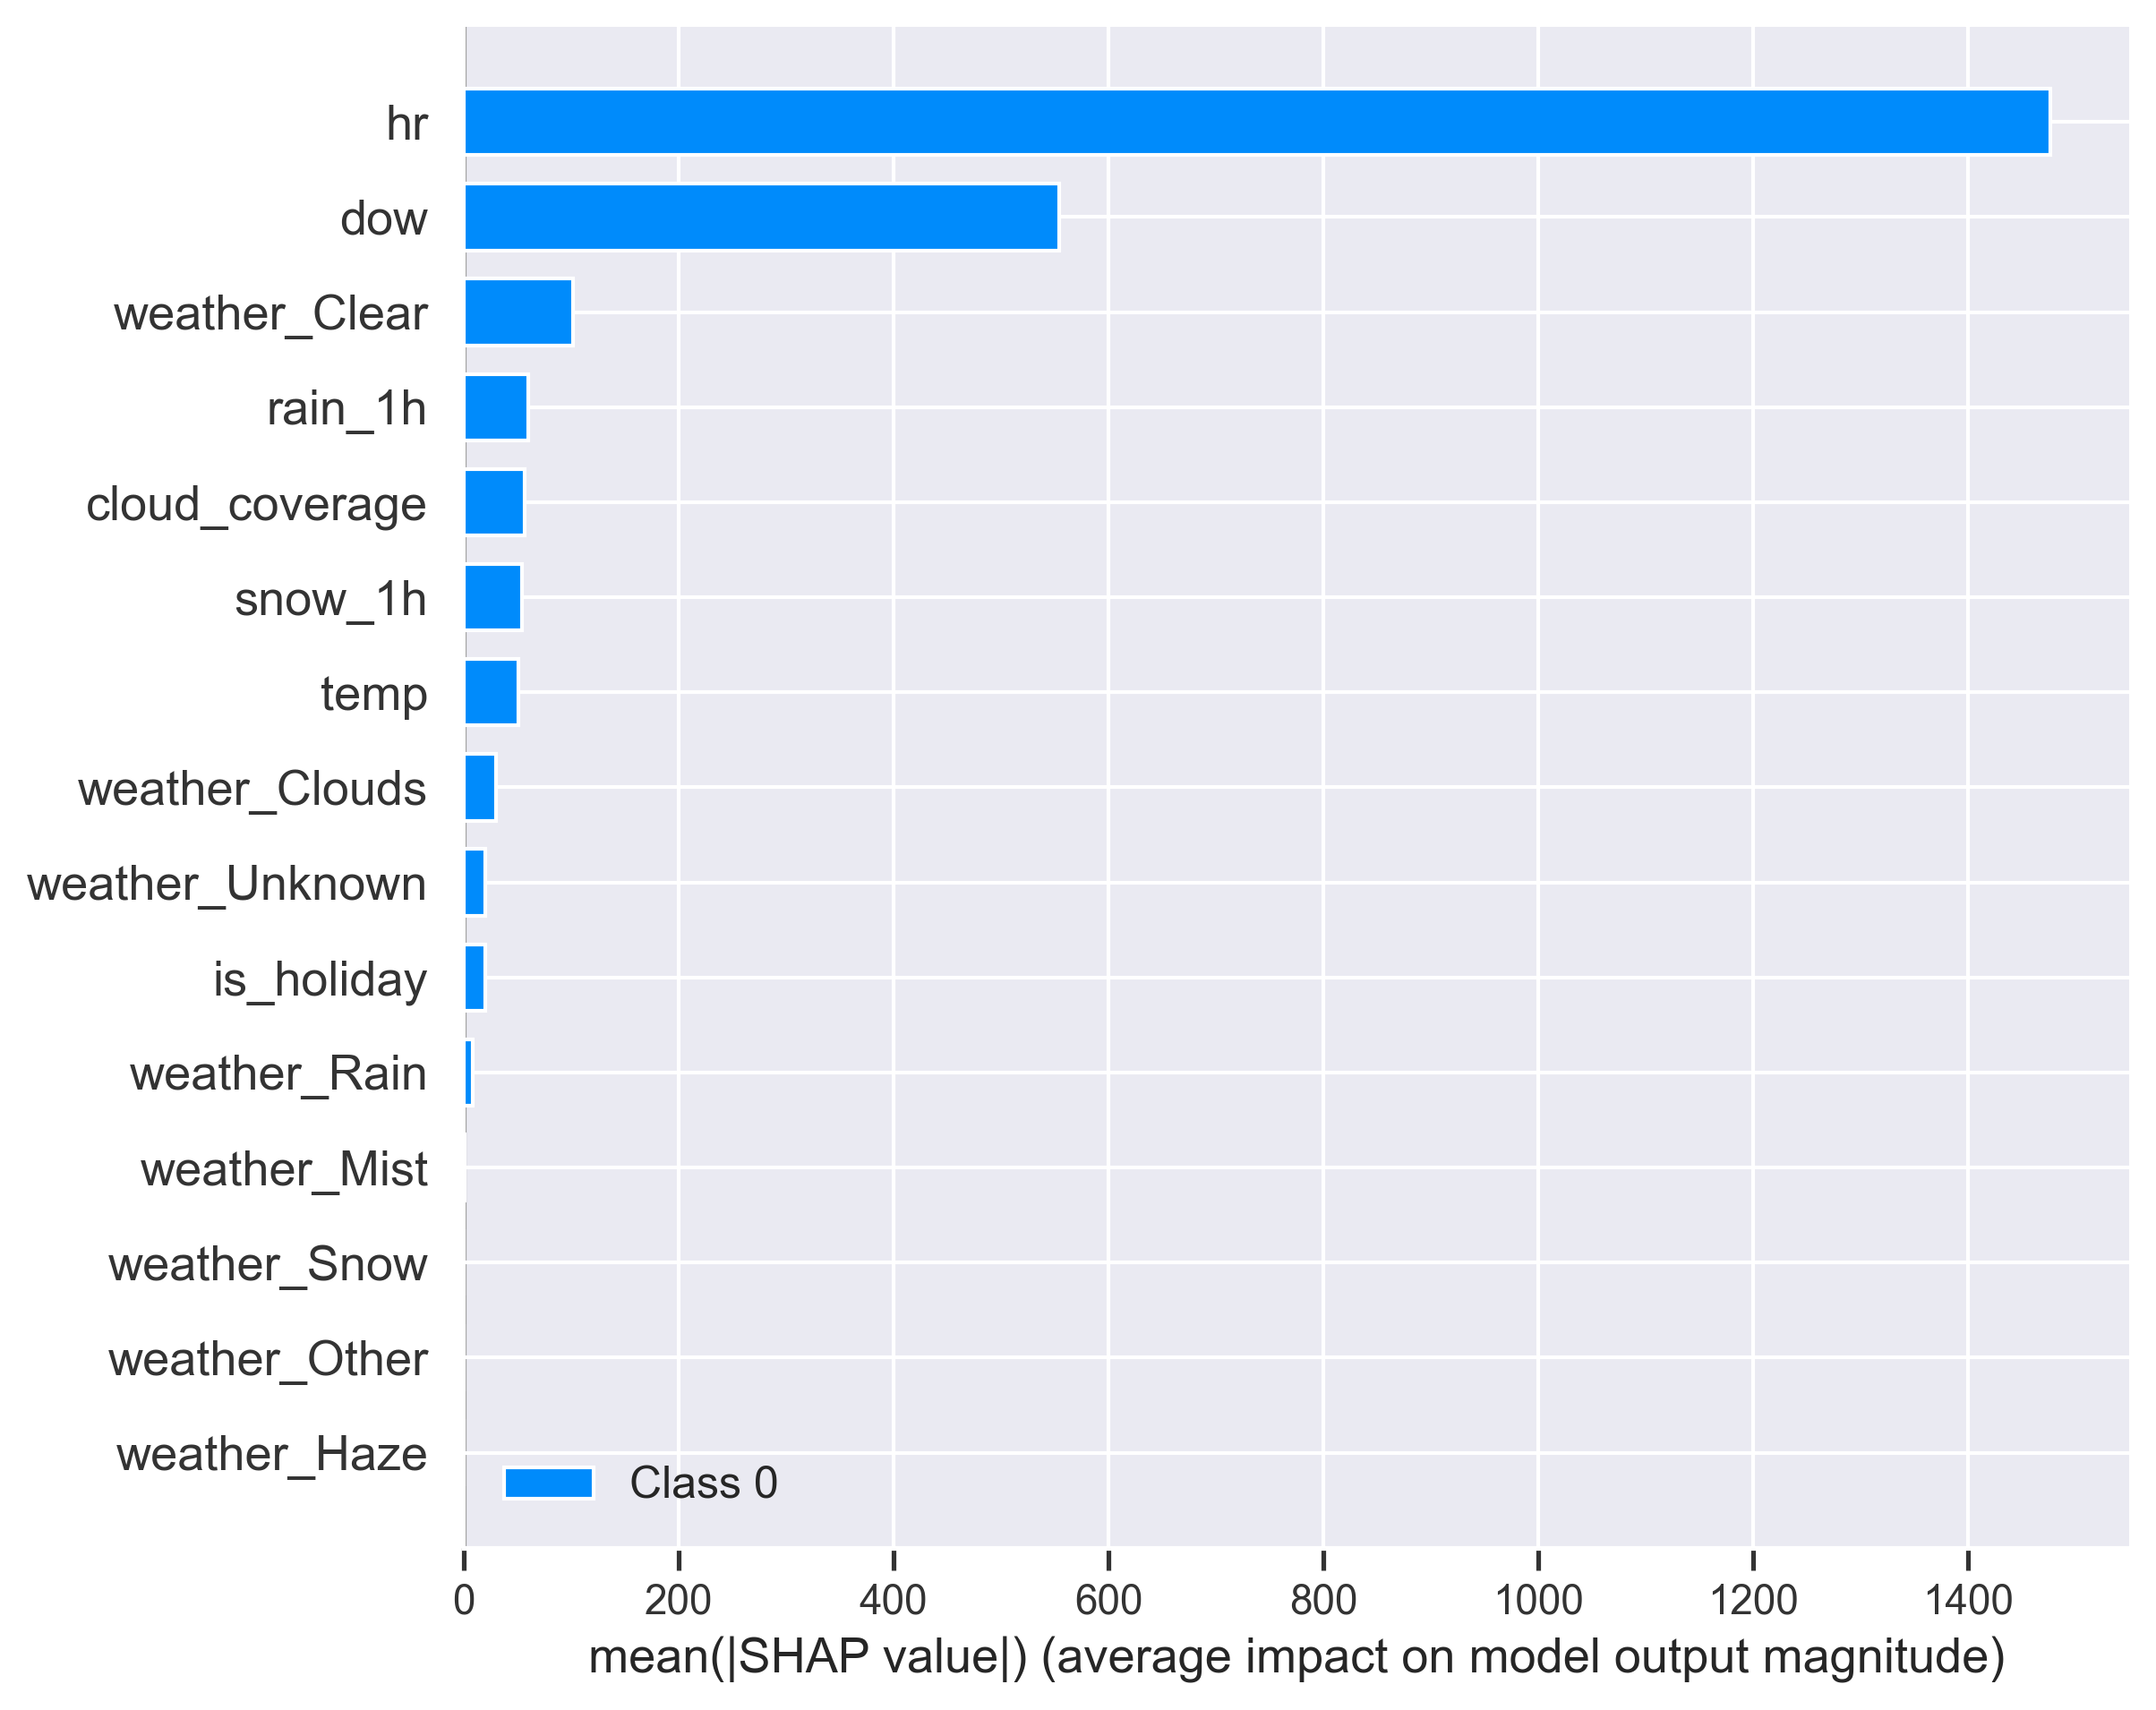

In [79]:
shap.summary_plot(shap_values, X_samp_df)

### Visualize Force Plots

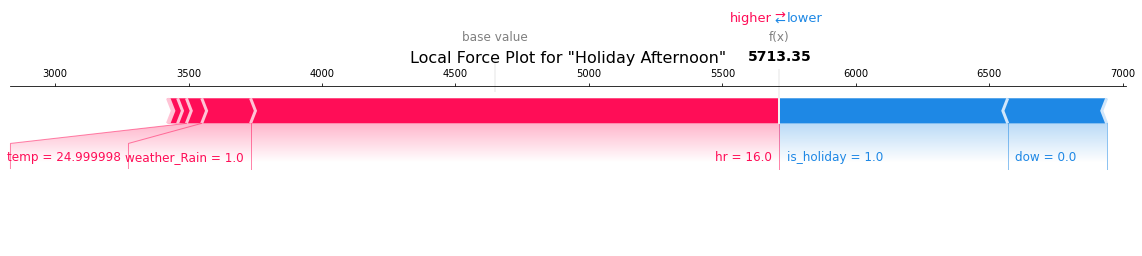

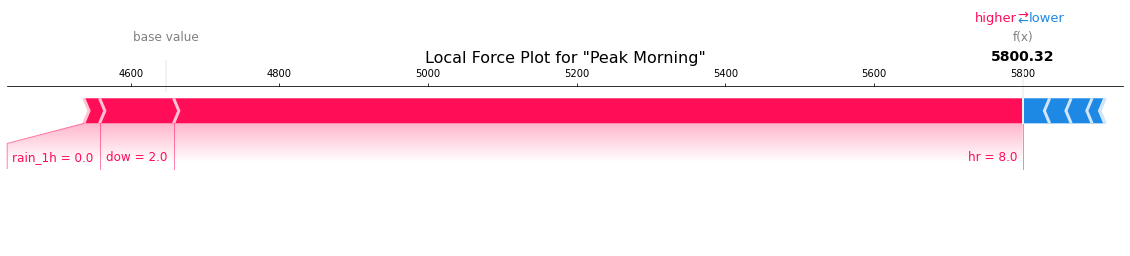

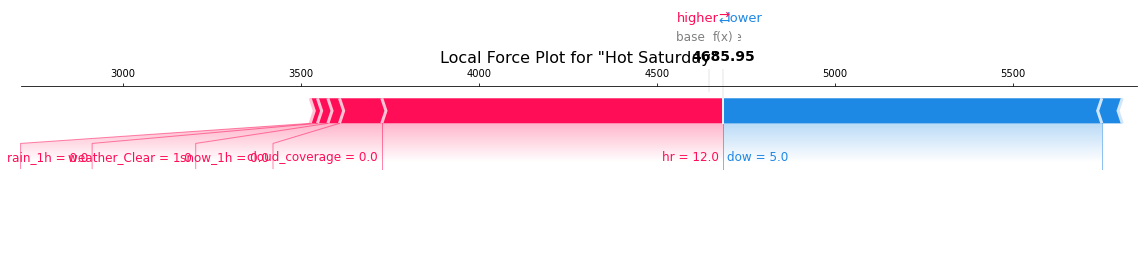

In [80]:
sns.reset_orig()

for s in range(len(samples)):
    print(sample_names[s])
    shap_values_single = explainer.shap_values(samples[s], nsamples=80)
    shap.force_plot(explainer.expected_value, shap_values_single[0],\
                    samples[s], matplotlib=True)
    plt.show()

## Identifying Influential Features with Factor Prioritization

### Computing Morris Sensitivity Indices

In [141]:
working_hrs_df = working_season_df[(working_season_df.dow < 5) &\
                                   ((working_season_df.hr < 5) |\
                                    (working_season_df.hr > 22))]

pd.set_option("display.precision", 2)
working_hrs_df.describe(percentiles=[.01,.5,.99]).transpose()

In [84]:
morris_problem = {
    # There are ten variables
    'num_vars': 10,
    # These are their names
    'names': ['dow', 'hr', 'temp', 'rain_1h', 'snow_1h',\
              'cloud_coverage', 'is_holiday',\
              'weather_Clear', 'weather_Clouds',\
              'weather_Rain'],
    # Plausible ranges over which we'll move the variables
    'bounds': [[0, 4], # dow
               [-1, 4], # hr
               [-12, 25.], # temp (C)
               [0., 3.1], # rain_1h
               [0., 0.3], # snow_1h
               [0., 100.], # cloud_coverage
               [0, 1], # is_holiday
               [0, 1], # weather_Clear 
               [0, 1], # weather_Clouds 
               [0, 1] # weather_Rain
              ],
    # Only weather is grouped together
    'groups': ['dow', 'hr', 'temp', 'rain_1h', 'snow_1h',\
              'cloud_coverage', 'is_holiday',\
               'weather', 'weather', 'weather']
}

In [85]:
morris_sample = ms.sample(morris_problem, 256,\
                          num_levels=4, seed=rand)
print(morris_sample.shape)

(2304, 10)


In [86]:
morris_sample_mod = np.hstack((morris_sample[:,0:9],\
                       np.zeros((morris_sample.shape[0],3)),\
                       morris_sample[:,9:10],\
                       np.zeros((morris_sample.shape[0],2))))
print(morris_sample_mod.shape)

(2304, 15)


In [87]:
morris_preds = mldatasets.\
                    approx_predict_ts(morris_sample_mod, X_df, gen_all,\
                              lstm_traffic_mdl, filt_fn=filt_fn,\
                              dist_metric=heom_dist.heom, lookback=lb,
                              X_scaler=X_scaler, y_scaler=y_scaler,\
                              progress_bar=True)

In [88]:
morris_sensitivities = ma.analyze(morris_problem, morris_sample,\
                                  morris_preds, print_to_console=False)

### Analyzing the Elementary Effects

In [122]:
morris_df = pd.DataFrame({'features':morris_sensitivities['names'],\
                          'μ':morris_sensitivities['mu'],\
                          'μ*':morris_sensitivities['mu_star'],\
                          'σ':morris_sensitivities['sigma']})
morris_df.sort_values('μ*', ascending=False).style.\
    background_gradient(cmap='plasma', subset=['μ*'])

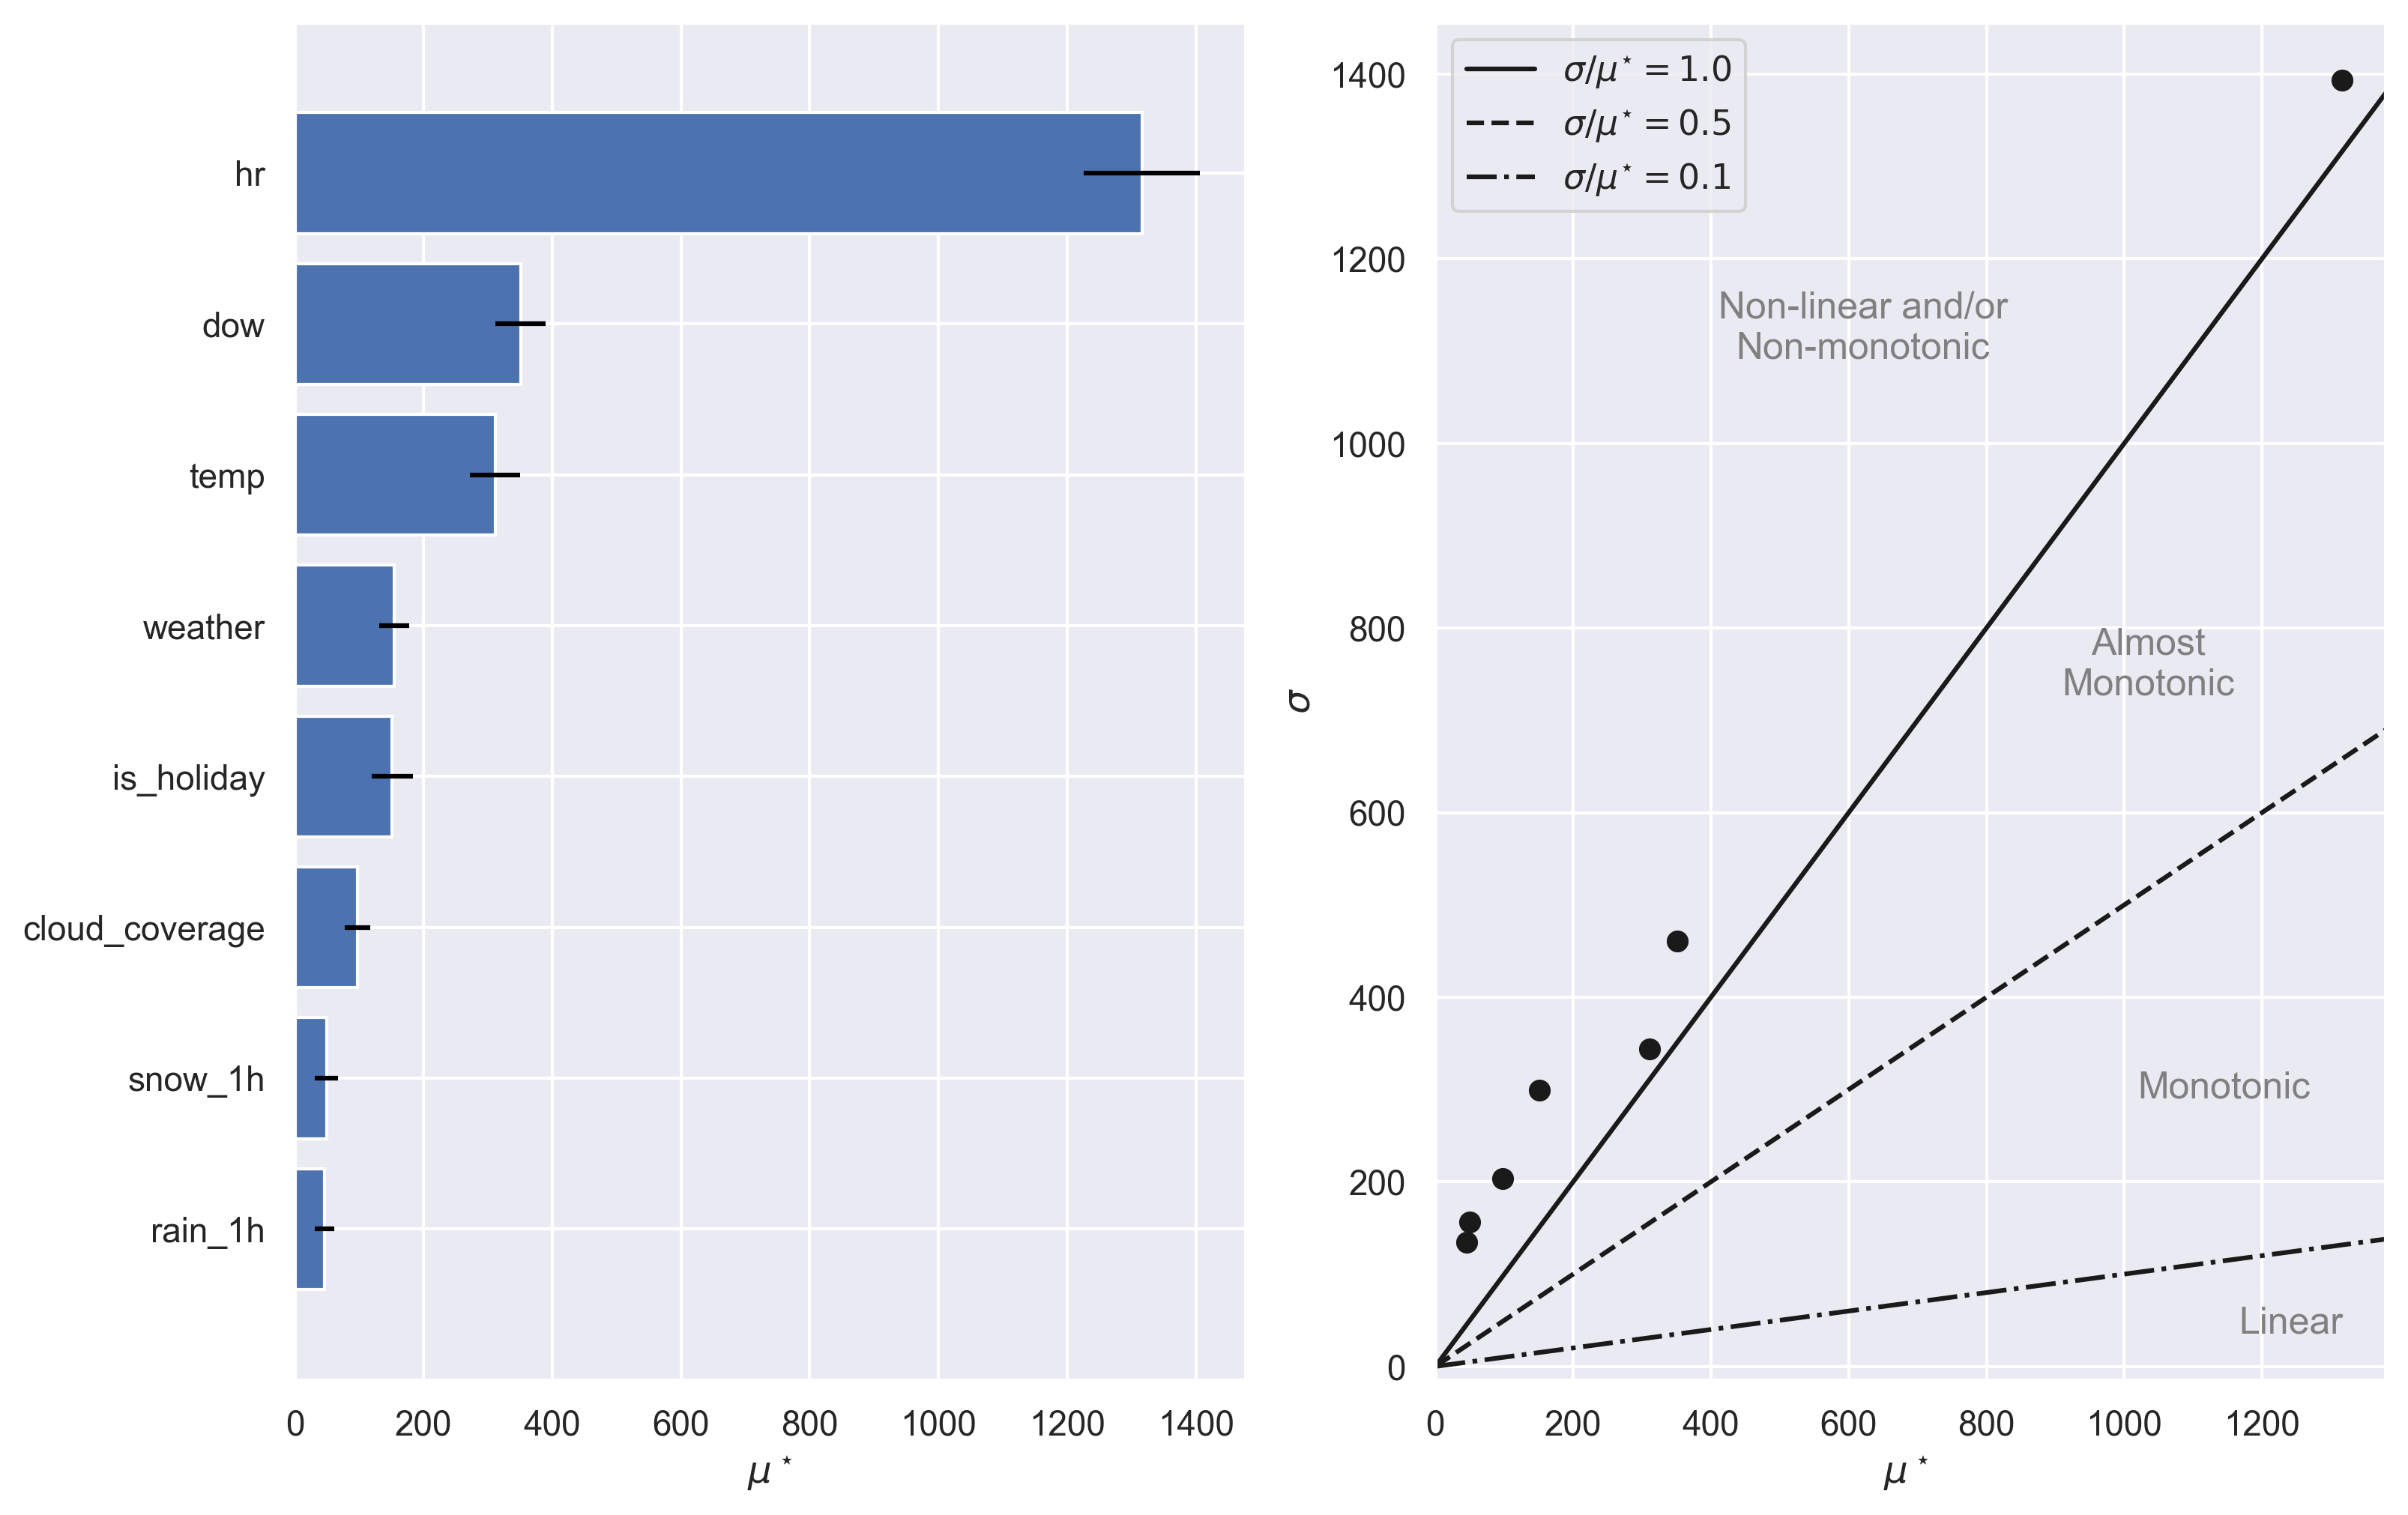

In [90]:
sns.set()

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,8))
mp.horizontal_bar_plot(ax0, morris_sensitivities, {})
mp.covariance_plot(ax1, morris_sensitivities, {})
ax1.text(ax1.get_xlim()[1]*0.45, ax1.get_ylim()[1]*0.75,\
         'Non-linear and/or\nNon-monotonic',\
         horizontalalignment='center', color='gray')
ax1.text(ax1.get_xlim()[1]*0.75, ax1.get_ylim()[1]*0.5,\
         'Almost\nMonotonic', horizontalalignment='center',\
         color='gray')
ax1.text(ax1.get_xlim()[1]*0.83, ax1.get_ylim()[1]*0.2,\
         'Monotonic', horizontalalignment='center', color='gray')
ax1.text(ax1.get_xlim()[1]*0.9, ax1.get_ylim()[1]*0.025,\
         'Linear', horizontalalignment='center', color='gray')
plt.show()

## Quantifying Uncertainty and Cost-Sensitivity with Factor Fixing

### Generating and Predicting on Salteli Samples

In [91]:
sobol_problem = {
    'num_vars': 8,
    'names': ['dow', 'hr', 'temp', 'rain_1h', 'snow_1h',\
              'cloud_coverage', 'is_holiday',\
              'weather_Clear'],
    'bounds': [[0, 4], # dow
               [-1, 4], # hr
               [-3., 31.], # temp (C)
               [0., 21.], # rain_1h
               [0., 1.6], # snow_1h
               [0., 100.], # cloud_coverage
               [0, 1], # is_holiday
               [0, 1] # weather_Clear
              ],
    'groups': None
}

In [92]:
saltelli_sample = ss.sample(sobol_problem, 256, calc_second_order=True)

saltelli_sample_mod = np.hstack((saltelli_sample,\
                       np.zeros((saltelli_sample.shape[0],7))))

print(saltelli_sample_mod.shape)

(4608, 15)


In [93]:
saltelli_preds = mldatasets.\
                    approx_predict_ts(saltelli_sample_mod, X_df, gen_all,\
                              lstm_traffic_mdl, filt_fn=filt_fn,\
                              dist_metric=heom_dist.heom, lookback=lb,
                              X_scaler=X_scaler, y_scaler=y_scaler,\
                              progress_bar=True)

In [94]:
print('Max Predicted Volume: %s' % '{:,.0f}'.format(max(saltelli_preds[:,0])))#1879.7686

Max Predicted Volume: 1,784


### Performing a Sobol Sensitivity Analysis

In [95]:
costs = np.where(saltelli_preds > 1500, 1,0)[:,0]
factor_fixing_sa = sa.analyze(sobol_problem, costs,\
                      calc_second_order=True, print_to_console=False)

In [123]:
sobol_df = pd.DataFrame({'features':sobol_problem['names'],\
                          '1st':factor_fixing_sa['S1'],\
                          'Total':factor_fixing_sa['ST'],\
                          'Total Conf':factor_fixing_sa['ST_conf'],\
                          'Mean of Input':saltelli_sample.mean(axis=0)[:8]})
sobol_df.sort_values('Total', ascending=False).style.\
    background_gradient(cmap='plasma', subset=['Total'])

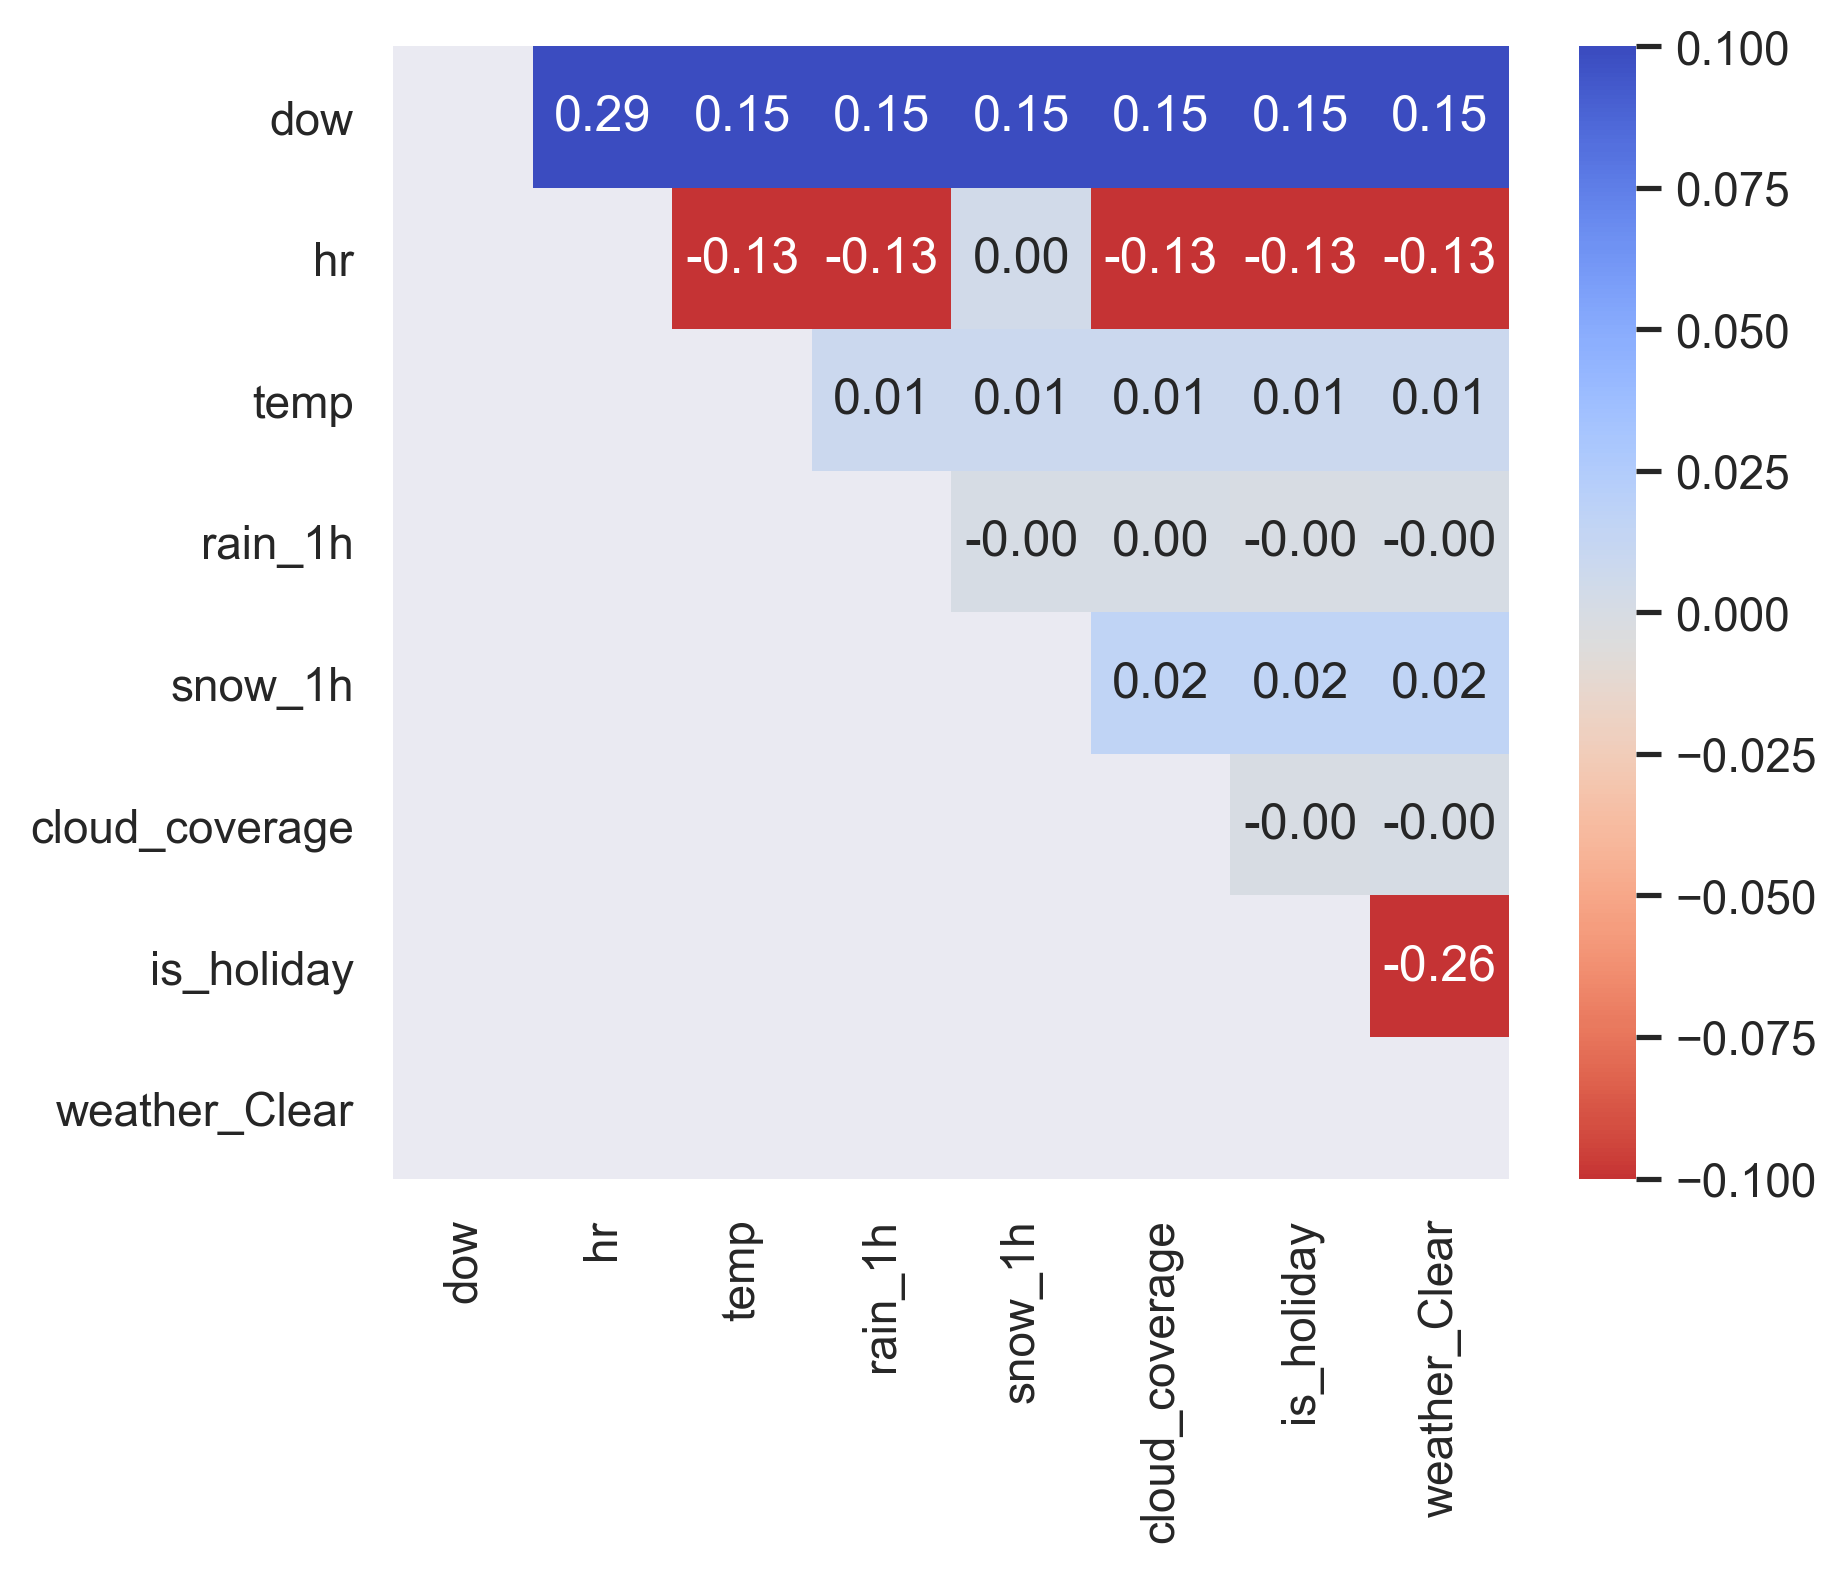

In [113]:
S2 = factor_fixing_sa['S2']

plt.figure(figsize=(6, 5))
divnorm = TwoSlopeNorm(vmin=S2.min(), vcenter=0, vmax=S2.max())
sns.heatmap(S2, center=0.00, norm=divnorm, cmap='coolwarm_r',\
            annot=True, fmt ='.2f',\
            xticklabels=sobol_problem['names'],\
            yticklabels=sobol_problem['names'])
plt.show()

### Incorporating a Realistic Cost Function

In [114]:
#Join input and outputs into a sample+prediction array
saltelli_sample_preds = np.hstack((saltelli_sample, saltelli_preds))

In [115]:
#Define cost function
def cost_fn(x):
    cost = 0
    if x[8] > 1500:
        cost = (x[8] - 1500) * 15
        if round(x[1]) == 4:
            cost = cost + 1500
            if round(x[0]) == 4:    
                cost = cost + 4500
    return cost

#Use list comprehension to compute costs for sample+prediction array
costs2 = np.array([cost_fn(xi) for xi in saltelli_sample_preds])

#Print total fines for entire sample predictions
print('Total Fines: $%s' % '{:,.2f}'.format(sum(costs2))) #119014.43115234375

Total Fines: $185,005.57


In [116]:
factor_fixing2_sa = sa.analyze(sobol_problem, costs2,\
                       calc_second_order=True, print_to_console=False)

In [124]:
sobol2_df = pd.DataFrame({'features':sobol_problem['names'],\
                          '1st':factor_fixing2_sa['S1'],\
                          'Total':factor_fixing2_sa['ST'],\
                          'Total Conf':factor_fixing2_sa['ST_conf'],\
                          'Mean of Input':saltelli_sample.mean(axis=0)[:8]})
sobol2_df.sort_values('Total', ascending=False).style.\
    background_gradient(cmap='plasma', subset=['Total'])

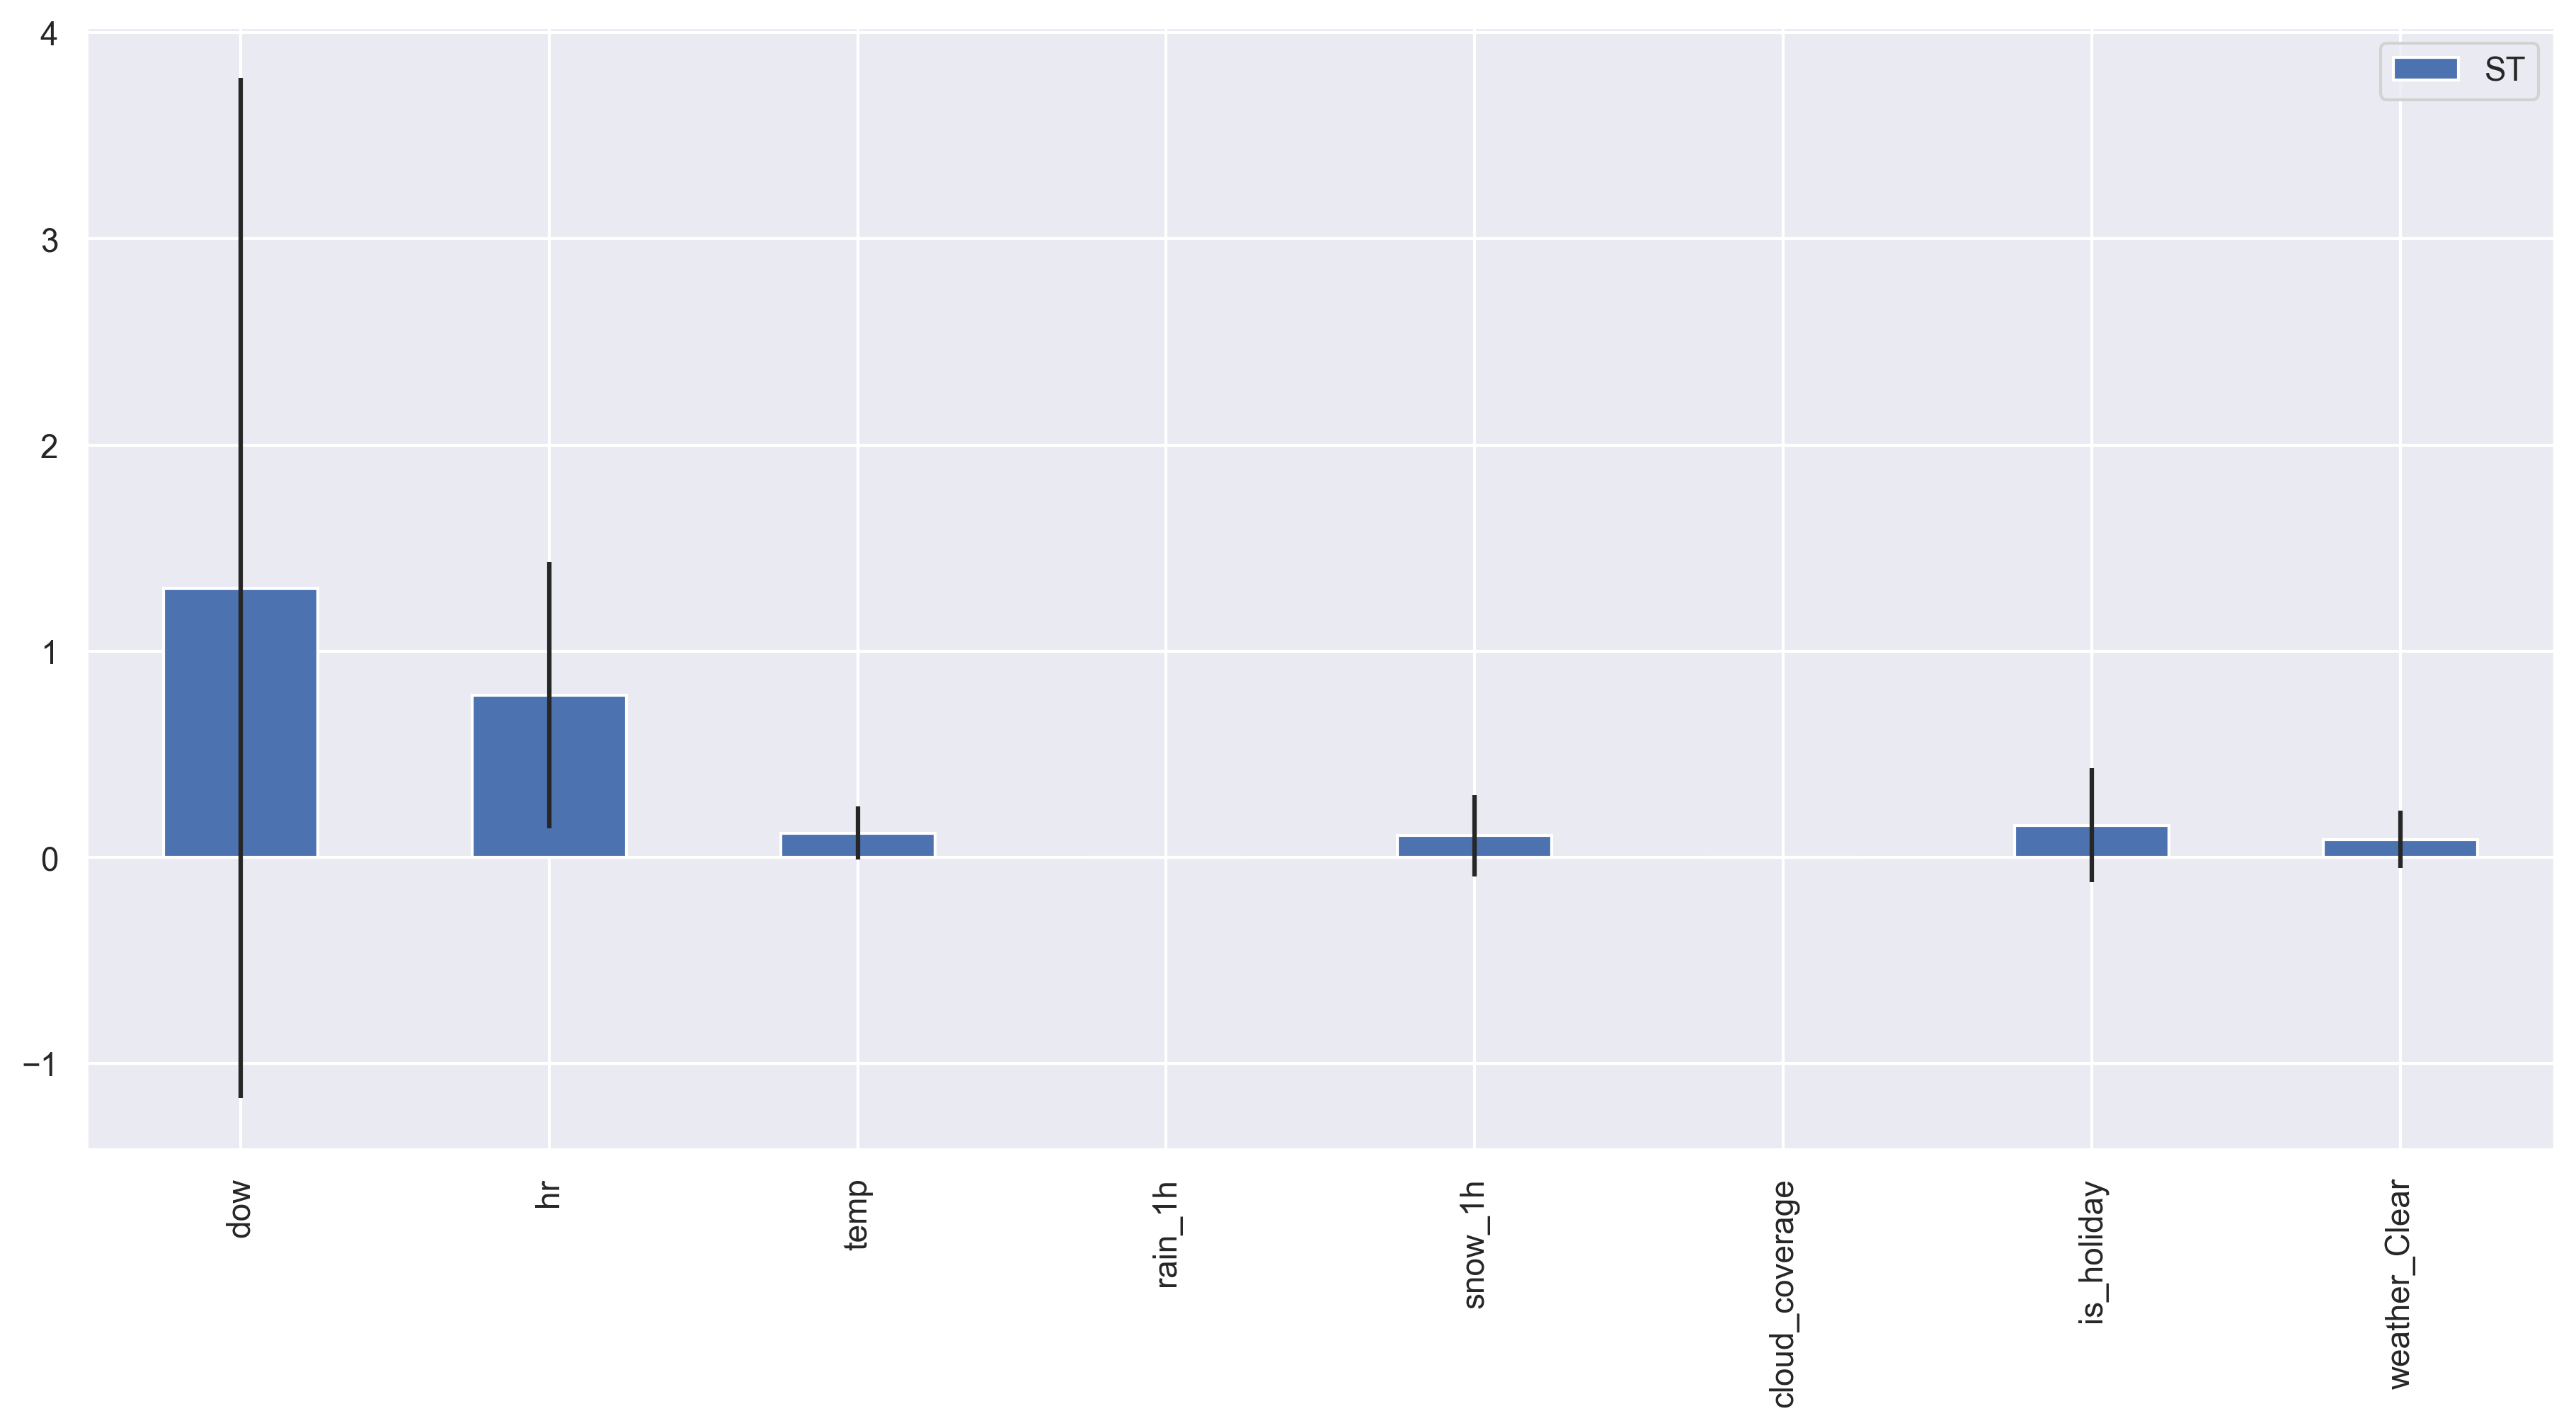

In [119]:
factor_fixing2_df = factor_fixing2_sa.to_df()
fig, (ax) = plt.subplots(1,1, figsize=(15, 7))
sp.plot(factor_fixing2_df[0], ax=ax)
plt.show()

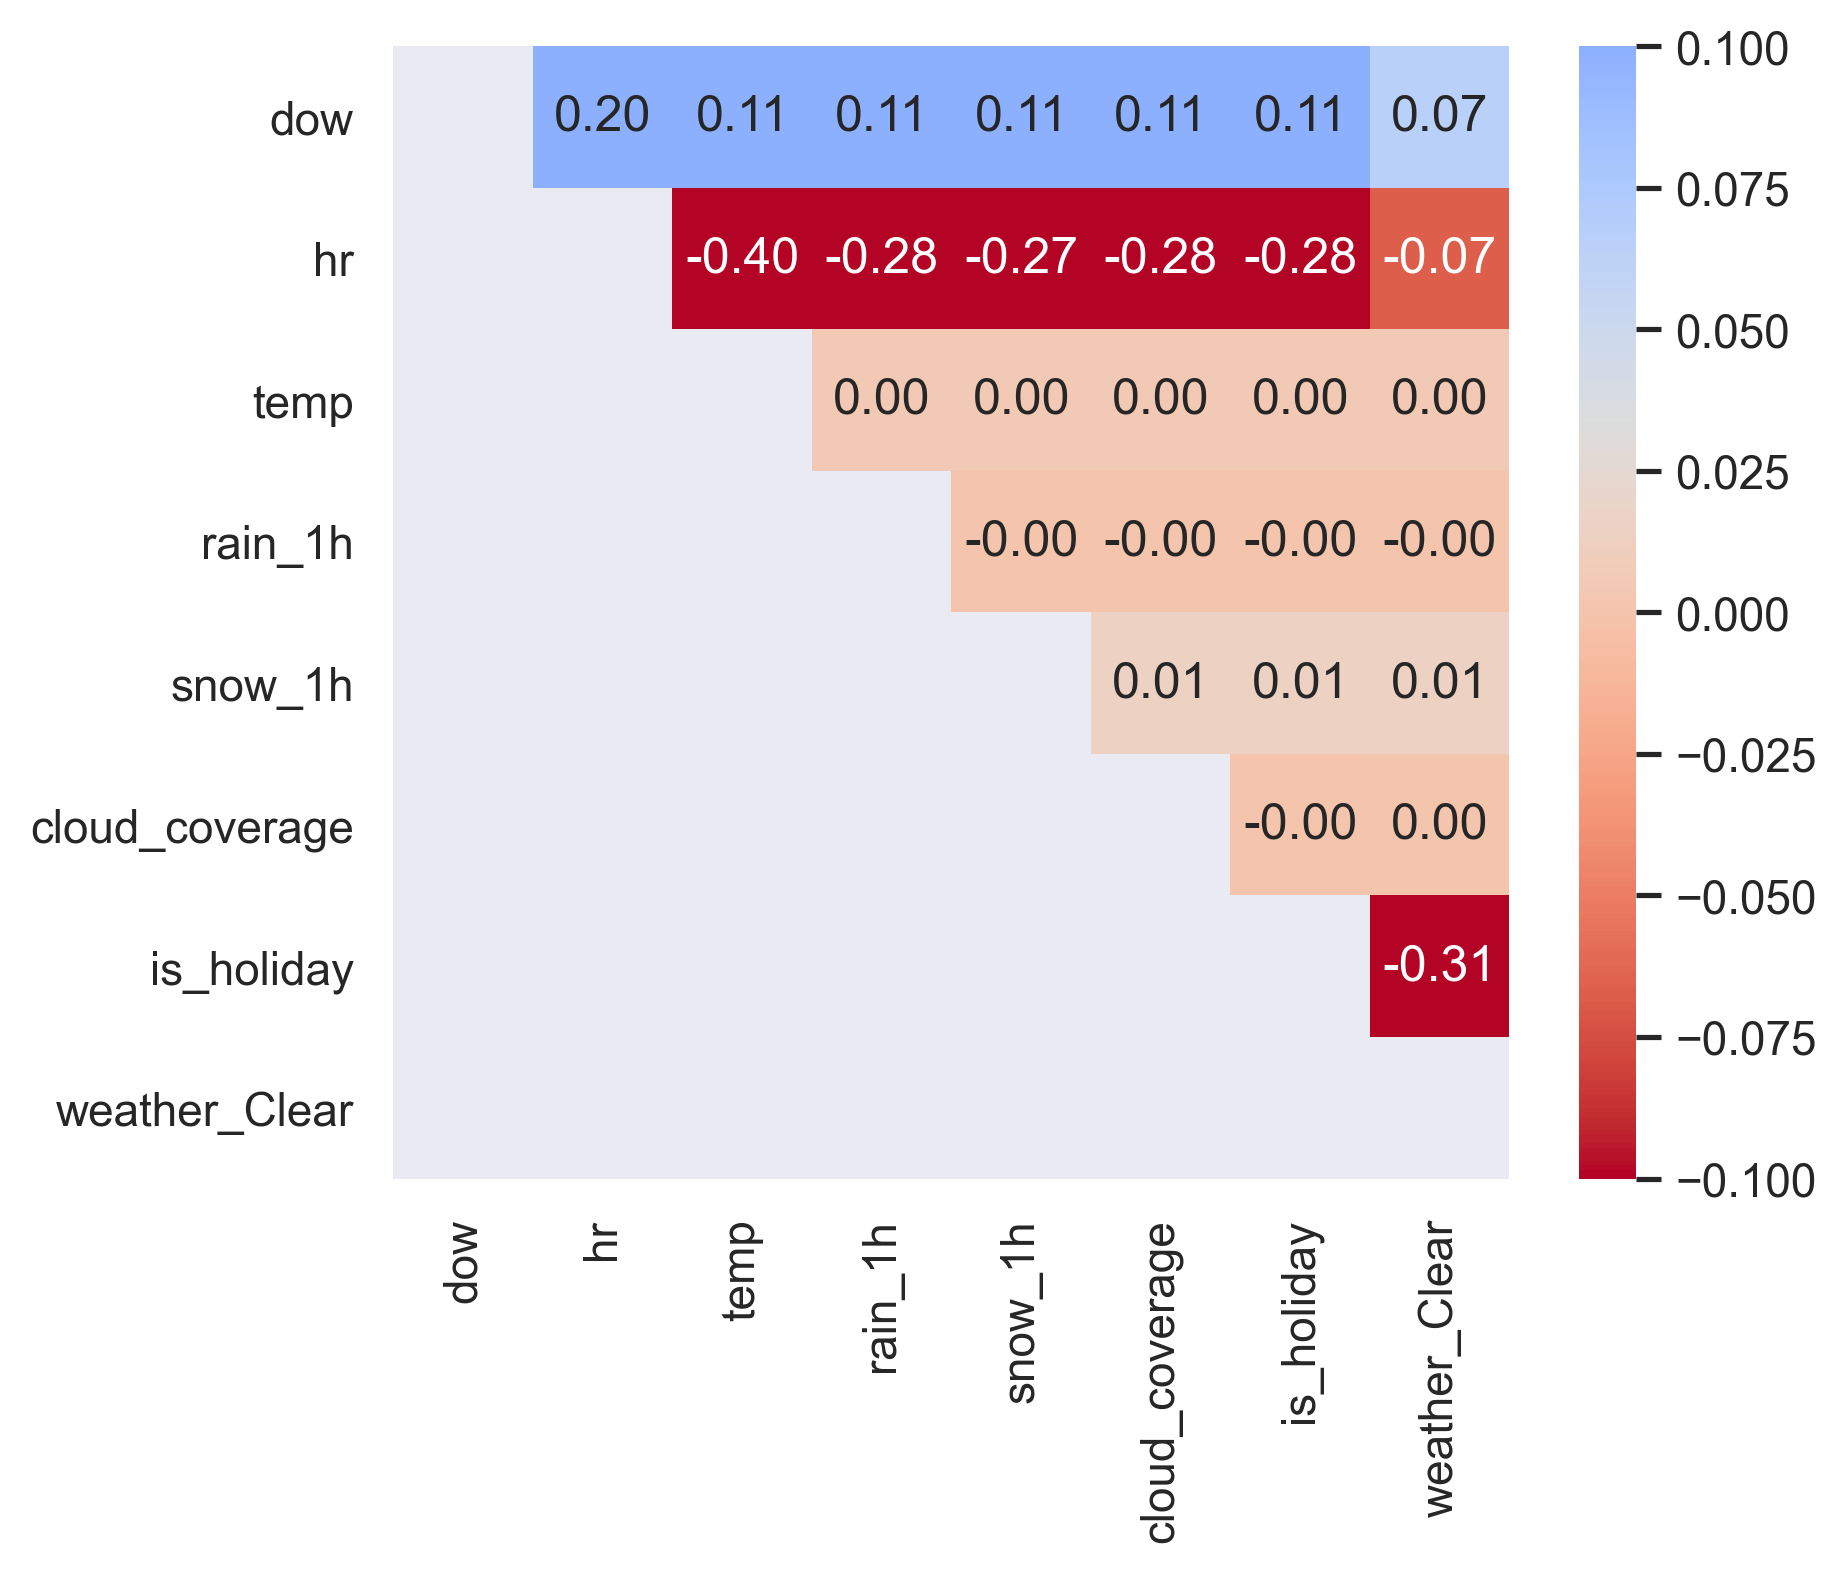

In [120]:
S2 = factor_fixing2_sa['S2']

plt.figure(figsize=(6, 5))
divnorm = TwoSlopeNorm(vmin=S2.min(), vcenter=0, vmax=S2.max())
sns.heatmap(S2, center=0.00, norm=divnorm, cmap='coolwarm_r',\
            annot=True, fmt ='.2f',\
            xticklabels=sobol_problem['names'],\
            yticklabels=sobol_problem['names'])
plt.show()